In [2]:
import pickle
from datetime import timedelta

from scipy.stats import norm, t
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import CovarianceShrinkage
import scipy.optimize as sc

# Data cleaning for risk free return

In [3]:
rf = pd.read_csv('data/F-F_Research_Data_Factors_daily.CSV', usecols=['Date', 'RF'])

In [4]:
rf['Date'] = pd.to_datetime(rf['Date'], format='%Y%m%d')
rf.set_index('Date', inplace=True)
rf = rf.resample('M').sum()
rf = np.log(rf/ 100 + 1)   #log return
rf = rf.loc['1994-04-30':'2022-04-30', :]

In [5]:
rf

RF
Date                
1994-04-30  0.002656
1994-05-31  0.003145
1994-06-30  0.003075
1994-07-31  0.002796
1994-08-31  0.003673
...              ...
2021-12-31  0.000000
2022-01-31  0.000000
2022-02-28  0.000000
2022-03-31  0.000000
2022-04-30  0.000000

[337 rows x 1 columns]

# Data cleaning for three factor and five factor

In [6]:
three_factor = pd.read_csv('data/F-F_Research_Data_Factors_daily.CSV', usecols=['Date', 'Mkt-RF','SMB','HML'])

In [7]:
three_factor['Date'] = pd.to_datetime(three_factor['Date'], format='%Y%m%d')
three_factor.set_index('Date', inplace=True)
three_factor = three_factor.resample('M').sum()
three_factor = np.log(three_factor/ 100 + 1)   #log return
three_factor = three_factor.loc['1994-04-30':'2022-04-30', :]

In [8]:
three_factor

Mkt-RF       SMB       HML
Date                                    
1994-04-30  0.007472 -0.008940  0.015873
1994-05-31  0.006876 -0.021019  0.006181
1994-06-30 -0.030872 -0.004611  0.017152
1994-07-31  0.027323 -0.017553  0.005982
1994-08-31  0.038547  0.013508 -0.024395
...              ...       ...       ...
2021-12-31  0.031402 -0.014200  0.029365
2022-01-31 -0.064752 -0.062620  0.123014
2022-02-28 -0.021224  0.022251  0.028296
2022-03-31  0.032467 -0.013896 -0.021121
2022-04-30 -0.101811 -0.015418  0.063632

[337 rows x 3 columns]

In [9]:
five_factor = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3_daily.CSV', usecols=['Date', 'Mkt-RF', 'SMB', 'HML'])
five_factor['Date'] = pd.to_datetime(five_factor['Date'], format='%Y%m%d')
five_factor.set_index('Date', inplace=True)
five_factor = five_factor.resample('M').sum()
five_factor = np.log(five_factor / 100 + 1)  #log return
five_factor = five_factor.loc['1994-04-30':'2022-04-30', :]
five_factor

Mkt-RF       SMB       HML
Date                                    
1994-04-30  0.007472 -0.009848  0.015873
1994-05-31  0.006876 -0.025215  0.006181
1994-06-30 -0.030872 -0.005515  0.017152
1994-07-31  0.027323 -0.017757  0.005982
1994-08-31  0.038547  0.013212 -0.024395
...              ...       ...       ...
2021-12-31  0.031402 -0.005616  0.029365
2022-01-31 -0.064752 -0.041343  0.123014
2022-02-28 -0.021224  0.028685  0.028296
2022-03-31  0.032467 -0.020203 -0.021121
2022-04-30 -0.101811 -0.004510  0.063632

[337 rows x 3 columns]

# Data cleaning for hedge fund dataset

In [10]:
hfd = pd.read_csv("data/NAVROR_full.csv", skiprows=1)

In [11]:
hfd

Date    HEDG HEDG_CVARB HEDG_EMMKT HEDG_EQNTR HEDG_EVDRV  \
0     2022-4-30   0.39%      0.48%     -1.17%     -0.91%     -0.80%   
1     2022-3-31   2.43%     -1.18%     -2.75%      0.24%      0.25%   
2     2022-2-28   0.37%     -0.35%     -2.71%      0.51%     -0.42%   
3     2022-1-31  -0.66%     -0.95%     -1.93%     -0.82%     -2.03%   
4    2021-12-31   1.92%      0.58%      0.07%      1.92%      0.26%   
..          ...     ...        ...        ...        ...        ...   
336   1994-4-30  -1.74%     -2.52%     -8.36%      0.25%     -0.66%   
337   1994-3-31  -3.57%     -0.97%     -4.61%     -0.24%     -1.29%   
338   1994-2-28  -4.09%      0.15%     -1.14%      0.24%     -0.15%   
339   1994-1-31   1.14%      0.36%     10.54%     -0.52%      3.68%   
340  1993-12-31   0.00%      0.00%      0.00%      0.00%      0.00%   

    HEDG_DISTR HEDG_MSEVD HEDG_MRARB HEDG_FIARB HEDG_GLMAC HEDG_LOSHO  \
0        0.14%     -0.95%     -1.25%     -0.54%      3.06%     -1.84%   
1        0.40%      0.23%      0.31%     -0.31%      8.79%      0.51%   
2        0.33%     -0.72%     -0.04%     -0.59%      3.26%     -1.44%   
3       -0.98%     -2.51%     -0.88%     -0.06%      3.44%     -2.43%   
4        0.76%      0.15%      0.01%      1.31%      3.49%      2.99%   
..         ...        ...        ...        ...        ...        ...   
336     -0.71%     -0.57%     -0.96%     -0.20%     -1.59%     -1.56%   
337     -1.83%     -0.83%      1.86%     -1.68%     -4.27%     -3.90%   
338     -0.34%      0.11%     -0.44%     -2.00%     -5.65%     -2.47%   
339      3.94%      3.60%      0.57%      1.30%      0.17%      1.20%   
340      0.00%      0.00%      0.00%      0.00%      0.00%      0.00%   

    HEDG_MGFUT HEDG_MULTI  
0        4.43%      1.27%  
1        8.49%      2.28%  
2        2.10%      2.03%  
3        1.43%     -1.20%  
4        0.21%      2.13%  
..         ...        ...  
336      0.86%      2.58%  
337      2.60%      0.00%  
338      1.20%        NaN  
339      0.22%        NaN  
340      0.00%        NaN  

[341 rows x 14 columns]

In [12]:
# hfd['Date'] = pd.to_datetime(hfd['Date'])
hfd.index = pd.to_datetime(hfd['Date'])
hfd.drop('Date', axis=1, inplace=True)
hfd.sort_index(ascending=True, inplace=True)
hfd.dropna(inplace=True)
#we need to delete the first row since it is just a marker, every strategy return 0
hfd.drop(hfd.index[0], inplace=True)

In [13]:
hfd

HEDG HEDG_CVARB HEDG_EMMKT HEDG_EQNTR HEDG_EVDRV HEDG_DISTR  \
Date                                                                        
1994-04-30  -1.74%     -2.52%     -8.36%      0.25%     -0.66%     -0.71%   
1994-05-31   2.23%     -1.02%     -0.73%     -0.11%     -0.15%     -0.84%   
1994-06-30  -0.81%      0.21%      0.47%      0.70%     -0.13%     -0.95%   
1994-07-31   0.35%      0.14%      5.81%     -1.00%      0.54%      1.80%   
1994-08-31   2.77%     -0.04%     16.42%     -0.99%      0.82%      2.04%   
...            ...        ...        ...        ...        ...        ...   
2021-12-31   1.92%      0.58%      0.07%      1.92%      0.26%      0.76%   
2022-01-31  -0.66%     -0.95%     -1.93%     -0.82%     -2.03%     -0.98%   
2022-02-28   0.37%     -0.35%     -2.71%      0.51%     -0.42%      0.33%   
2022-03-31   2.43%     -1.18%     -2.75%      0.24%      0.25%      0.40%   
2022-04-30   0.39%      0.48%     -1.17%     -0.91%     -0.80%      0.14%   

           HEDG_MSEVD HEDG_MRARB HEDG_FIARB HEDG_GLMAC HEDG_LOSHO HEDG_MGFUT  \
Date                                                                           
1994-04-30     -0.57%     -0.96%     -0.20%     -1.59%     -1.56%      0.86%   
1994-05-31      0.69%      0.25%      0.79%      3.80%      0.57%      0.76%   
1994-06-30      0.83%      0.18%     -0.40%     -0.92%     -2.31%      4.15%   
1994-07-31     -0.96%      0.57%     -0.18%     -0.35%      1.29%     -1.01%   
1994-08-31     -0.72%      1.69%     -0.09%      2.75%      1.64%     -0.27%   
...               ...        ...        ...        ...        ...        ...   
2021-12-31      0.15%      0.01%      1.31%      3.49%      2.99%      0.21%   
2022-01-31     -2.51%     -0.88%     -0.06%      3.44%     -2.43%      1.43%   
2022-02-28     -0.72%     -0.04%     -0.59%      3.26%     -1.44%      2.10%   
2022-03-31      0.23%      0.31%     -0.31%      8.79%      0.51%      8.49%   
2022-04-30     -0.95%     -1.25%     -0.54%      3.06%     -1.84%      4.43%   

           HEDG_MULTI  
Date                   
1994-04-30      2.58%  
1994-05-31     -3.47%  
1994-06-30      3.61%  
1994-07-31     -2.23%  
1994-08-31     -3.24%  
...               ...  
2021-12-31      2.13%  
2022-01-31     -1.20%  
2022-02-28      2.03%  
2022-03-31      2.28%  
2022-04-30      1.27%  

[337 rows x 13 columns]

In [14]:
hfd_name = pd.read_csv("data/NAVROR_full.csv", nrows=1).drop('Unnamed: 0', axis=1)

In [15]:
hfd_fullname = {
    hfd_name.loc[0].tolist()[i]: hfd_name.columns.tolist()[i].removeprefix('Credit Suisse ').removesuffix(
        ' Hedge Fund Index') for i in range(len(hfd_name.loc[0]))
}

In [16]:
list(hfd_fullname.values())

['Hedge Fund Index ',
 'Convertible Arbitrage',
 'Emerging Markets',
 'Equity Market Neutral',
 'Event Driven',
 'Event Driven Distressed',
 'Event Driven Multi-Strategy',
 'Event Driven Risk Arbitrage',
 'Fixed Income Arbitrage',
 'Global Macro',
 'Long/Short Equity',
 'Managed Futures',
 'Multi-Strategy']

In [17]:
#change % to real value
for col in hfd.columns:
    hfd[col] = hfd[col].str.rstrip('%').astype('float') / 100.0

In [18]:
#change simple return to log return
hfd = np.log(hfd + 1)

In [19]:
#take the excess return
hfd = hfd.join(rf)
for col in hfd.columns:
    hfd[col] = hfd[col] - hfd['RF']
del hfd['RF']

In [20]:
hfd

HEDG  HEDG_CVARB  HEDG_EMMKT  HEDG_EQNTR  HEDG_EVDRV  \
Date                                                                   
1994-04-30 -0.020210   -0.028179   -0.089959   -0.000160   -0.009278   
1994-05-31  0.018910   -0.013397   -0.010472   -0.004246   -0.004646   
1994-06-30 -0.011208   -0.000977    0.001614    0.003900   -0.004376   
1994-07-31  0.000698   -0.001397    0.053679   -0.012846    0.002589   
1994-08-31  0.023650   -0.004073    0.148361   -0.013623    0.004493   
...              ...         ...         ...         ...         ...   
2021-12-31  0.019018    0.005783    0.000700    0.019018    0.002597   
2022-01-31 -0.006622   -0.009545   -0.019489   -0.008234   -0.020509   
2022-02-28  0.003693   -0.003506   -0.027474    0.005087   -0.004209   
2022-03-31  0.024009   -0.011870   -0.027885    0.002397    0.002497   
2022-04-30  0.003892    0.004789   -0.011769   -0.009142   -0.008032   

            HEDG_DISTR  HEDG_MSEVD  HEDG_MRARB  HEDG_FIARB  HEDG_GLMAC  \
Date                                                                     
1994-04-30   -0.009782   -0.008373   -0.012303   -0.004658   -0.018684   
1994-05-31   -0.011581    0.003731   -0.000648    0.004724    0.034151   
1994-06-30   -0.012621    0.005190   -0.001277   -0.007083   -0.012318   
1994-07-31    0.015044   -0.012442    0.002888   -0.004598   -0.006302   
1994-08-31    0.016521   -0.010899    0.013086   -0.004574    0.023455   
...                ...         ...         ...         ...         ...   
2021-12-31    0.007571    0.001499    0.000100    0.013015    0.034305   
2022-01-31   -0.009848   -0.025420   -0.008839   -0.000600    0.033822   
2022-02-28    0.003295   -0.007226   -0.000400   -0.005917    0.032080   
2022-03-31    0.003992    0.002297    0.003095   -0.003105    0.084249   
2022-04-30    0.001399   -0.009545   -0.012579   -0.005415    0.030141   

            HEDG_LOSHO  HEDG_MGFUT  HEDG_MULTI  
Date                                            
1994-04-30   -0.018379    0.005907    0.022816  
1994-05-31    0.002539    0.004426   -0.038461  
1994-06-30   -0.026446    0.037587    0.032388  
1994-07-31    0.010021   -0.012947   -0.025348  
1994-08-31    0.012594   -0.006377   -0.036610  
...                ...         ...         ...  
2021-12-31    0.029462    0.002098    0.021076  
2022-01-31   -0.024600    0.014199   -0.012073  
2022-02-28   -0.014505    0.020783    0.020097  
2022-03-31    0.005087    0.081488    0.022544  
2022-04-30   -0.018571    0.043347    0.012620  

[337 rows x 13 columns]

In [21]:
fig = px.line(hfd.cumsum().rename(columns=hfd_fullname), title='Cumulative Log Monthly Return of Hedge Fund Strategy')
fig.show()

In [22]:
hfd.describe()

HEDG  HEDG_CVARB  HEDG_EMMKT  HEDG_EQNTR  HEDG_EVDRV  HEDG_DISTR  \
count  337.000000  337.000000  337.000000  337.000000  337.000000  337.000000   
mean     0.004359    0.003352    0.003315    0.001348    0.004264    0.004884   
std      0.018945    0.017927    0.037410    0.030725    0.019296    0.018200   
min     -0.082693   -0.135480   -0.265946   -0.518544   -0.145998   -0.137151   
25%     -0.003562   -0.002361   -0.011263   -0.002804   -0.002972   -0.003005   
50%      0.004459    0.005165    0.007823    0.003279    0.006081    0.007303   
75%      0.014143    0.011116    0.021859    0.009447    0.015022    0.014889   
max      0.077466    0.056475    0.148361    0.042485    0.065319    0.066724   

       HEDG_MSEVD  HEDG_MRARB  HEDG_FIARB  HEDG_GLMAC  HEDG_LOSHO  HEDG_MGFUT  \
count  337.000000  337.000000  337.000000  337.000000  337.000000  337.000000   
mean     0.003944    0.002845    0.002291    0.006419    0.004812    0.002203   
std      0.021469    0.012514    0.014831    0.024280    0.025396    0.032148   
min     -0.170803   -0.067664   -0.152208   -0.126027   -0.125568   -0.102555   
25%     -0.003392   -0.002499   -0.000679   -0.003792   -0.010034   -0.017776   
50%      0.005750    0.003270    0.004092    0.006871    0.005485    0.001496   
75%      0.015172    0.009075    0.008259    0.016365    0.018724    0.025168   
max      0.066630    0.058740    0.042389    0.096160    0.117916    0.090664   

       HEDG_MULTI  
count  337.000000  
mean     0.004088  
std      0.014324  
min     -0.077810  
25%     -0.001685  
50%      0.005673  
75%      0.012126  
max      0.041909

In [23]:
fig = px.imshow(hfd.rename(columns=hfd_fullname).corr())
fig.update_layout(
    title_text='Hedge Fund Strategy Correlation Heatmap'
)
fig.show()

In [24]:
fig = make_subplots(rows=5, cols=3, subplot_titles=list(hfd_fullname.values()))
row = 0
for idx, fd in enumerate(hfd.columns):
    if idx % 3 == 0:
        row += 1
    fig.append_trace(
        go.Histogram(x=hfd.loc[:, fd],
                     name=hfd_fullname[fd],
                     autobinx=True),
        row=row,
        col=idx % 3 + 1
    )

fig.update_layout(
    height=1000,
    title_text='Hedge Fund Strategy Return Density Distribution',  # title of plot
    bargap=0.1,  # gap between bars of adjacent location coordinates
)

fig.show()

In [25]:
def Omega_ratio(df,threashold=0):
    '''

    :param df:one dimensional array
    :param threashold:
    :return:
    '''
    daily_threashold = (threashold+1)**np.sqrt(1/252)-1
    r = np.array(df)
    excess = r-daily_threashold
    return np.sum(excess[excess>0])/(-np.sum(excess[excess<0]))

def Omega_Curve(df,thresholds = np.linspace(0,0.2,50)):
    omega_value=[]
    for i in thresholds:
        omega_value.append(Omega_ratio(df,i))
    return omega_value

In [26]:
def annualized_sharpe_ratio(ret):
    #only for excess return (rf already deducted)
    ret = np.array(ret)
    return np.mean(ret)/np.std(ret)*np.sqrt(12)

def OLS_alpha(ret,X):
    res = sm.OLS(ret,sm.add_constant(X)).fit()
    return res.params[0]


# Data cleaning for ETF

In [27]:
etf_name = pd.read_csv("data/ETF_data.csv", nrows=1).dropna(axis=1)

In [28]:
etf_fullname = {
    etf_name.loc[0].tolist()[i]: etf_name.columns.tolist()[i].removesuffix(
        ' Value Unhedged USD').replace(' Total Return', '').replace('.1', '').replace('Cboe ', '').replace(' Index', '') for i in range(len(etf_name.loc[0]))
}

In [29]:
etf_fullname

{'LUMSTRUU': 'Bloomberg US MBS',
 'LT09STAT': 'Bloomberg U.S. Treasury: 7-10 Year Statistics',
 'WGBI': 'FTSE World Government Bond',
 'EMUSTRUU': 'Bloomberg EM USD Aggregate',
 'TWEXB': 'Trade Weighted U.S. Dollar',
 'SPGSCI_PM': 'S&P GSCI Precious Metals',
 'SPGSCI_Gra': 'S&P GSCI Grains',
 'SPGSCI_O': 'S&P GSCI Crude Oil',
 'LCB1TRUU': 'Bloomberg Baa Corporate',
 'MSCI_EXUS': 'MSCI World ex USA',
 'MSCI_EM': 'MSCI Emerging Markets',
 'R1000': 'Russell 1000',
 'R200': 'Russell 2000',
 'FTSE_REIT': 'FTSE Nareit US Real Estatees',
 'VIX': 'VIX',
 'PUT': 'S&P 500 PutWrite',
 'PUTY': 'S&P 500 2% OTM PutWrite',
 'CLL': 'S&P 500 95-110 Collar',
 'BFLY': 'S&P 500 Iron Butterfly',
 'BXM': 'S&P 500 BuyWrite',
 'BXY': 'S&P 500 2% OTM BuyWrite',
 'CLLZ': 'S&P 500 Zero-Cost Put Spread Collar',
 'PCRTEQTY': 'CBOE Equity Put/Call Ratio Intraday',
 'PCRTTOTL': 'CBOE Equity Put/Call Ratio Composite Intraday',
 'RYLD': 'Russell 2000 Covered Call ETF',
 'SP_STRAD': 'S&P 500 Delta Hedged Straddle',
 'S

In [30]:
# because different data has different frequency,
# we first read in data by loop, then handle each dataframe seperately.
# the goal is to match hfd (337 row monthly log return)
count = 0
return_list = []
for idx, etf in enumerate(etf_fullname.keys()):
    '''
        idx -> columns -> un-name num
        0 -> 0,1 -> 0
        1 -> 2,3 -> 2
        2 -> 4,5 -> 4
    '''
    if idx == 0:
        count += 1
        n = 0
    else:
        count += 2
        n = count - 1
    df = pd.read_csv('data/ETF_data.csv', skiprows=1, usecols=[count - 1, count]).rename(columns={f'Unnamed: {n}': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = np.log(df / df.shift(1))
    df = df.dropna()
    df = df.resample('M').sum().loc['1994-04-30':'2022-04-30', :]
    return_list.append(df)

In [31]:
for df in return_list:
    print(len(df), df.columns)

337 Index(['LUMSTRUU'], dtype='object')
337 Index(['LT09STAT'], dtype='object')
337 Index(['WGBI'], dtype='object')
337 Index(['EMUSTRUU'], dtype='object')
337 Index(['TWEXB'], dtype='object')
337 Index(['SPGSCI_PM'], dtype='object')
337 Index(['SPGSCI_Gra'], dtype='object')
337 Index(['SPGSCI_O'], dtype='object')
337 Index(['LCB1TRUU'], dtype='object')
337 Index(['MSCI_EXUS'], dtype='object')
337 Index(['MSCI_EM'], dtype='object')
337 Index(['R1000'], dtype='object')
337 Index(['R200'], dtype='object')
337 Index(['FTSE_REIT'], dtype='object')
337 Index(['VIX'], dtype='object')
337 Index(['PUT'], dtype='object')
337 Index(['PUTY'], dtype='object')
337 Index(['CLL'], dtype='object')
337 Index(['BFLY'], dtype='object')
337 Index(['BXM'], dtype='object')
337 Index(['BXY'], dtype='object')
337 Index(['CLLZ'], dtype='object')
328 Index(['PCRTEQTY'], dtype='object')
328 Index(['PCRTTOTL'], dtype='object')
40 Index(['RYLD'], dtype='object')
196 Index(['SP_STRAD'], dtype='object')
76 Index(['S

In [32]:
# Due to observation limitation, we leave out the rest starting from RYLD.
factor_etf_name = etf_fullname.copy()
remove_keys= ['RYLD', 'SP_STRAD', 'SMILE', 'SPRO', 'VVIX', 'VXEEM','JPMVXYEM', 'CMBOEA', 'CMBOEF', 'CNDREF', 'CNDREA', 'BFLYEA', 'BFLYEF','CLLR', 'SPRF','XYLD','PCRTEQTY','PCRTTOTL']
for key in remove_keys:
    del factor_etf_name[key]

In [33]:
factor_etf_name

{'LUMSTRUU': 'Bloomberg US MBS',
 'LT09STAT': 'Bloomberg U.S. Treasury: 7-10 Year Statistics',
 'WGBI': 'FTSE World Government Bond',
 'EMUSTRUU': 'Bloomberg EM USD Aggregate',
 'TWEXB': 'Trade Weighted U.S. Dollar',
 'SPGSCI_PM': 'S&P GSCI Precious Metals',
 'SPGSCI_Gra': 'S&P GSCI Grains',
 'SPGSCI_O': 'S&P GSCI Crude Oil',
 'LCB1TRUU': 'Bloomberg Baa Corporate',
 'MSCI_EXUS': 'MSCI World ex USA',
 'MSCI_EM': 'MSCI Emerging Markets',
 'R1000': 'Russell 1000',
 'R200': 'Russell 2000',
 'FTSE_REIT': 'FTSE Nareit US Real Estatees',
 'VIX': 'VIX',
 'PUT': 'S&P 500 PutWrite',
 'PUTY': 'S&P 500 2% OTM PutWrite',
 'CLL': 'S&P 500 95-110 Collar',
 'BFLY': 'S&P 500 Iron Butterfly',
 'BXM': 'S&P 500 BuyWrite',
 'BXY': 'S&P 500 2% OTM BuyWrite',
 'CLLZ': 'S&P 500 Zero-Cost Put Spread Collar'}

In [34]:
len(factor_etf_name)

22

In [35]:
factor_etf_data_list = return_list[:22].copy()

In [36]:
for df in factor_etf_data_list:
    print(len(df), df.columns)

337 Index(['LUMSTRUU'], dtype='object')
337 Index(['LT09STAT'], dtype='object')
337 Index(['WGBI'], dtype='object')
337 Index(['EMUSTRUU'], dtype='object')
337 Index(['TWEXB'], dtype='object')
337 Index(['SPGSCI_PM'], dtype='object')
337 Index(['SPGSCI_Gra'], dtype='object')
337 Index(['SPGSCI_O'], dtype='object')
337 Index(['LCB1TRUU'], dtype='object')
337 Index(['MSCI_EXUS'], dtype='object')
337 Index(['MSCI_EM'], dtype='object')
337 Index(['R1000'], dtype='object')
337 Index(['R200'], dtype='object')
337 Index(['FTSE_REIT'], dtype='object')
337 Index(['VIX'], dtype='object')
337 Index(['PUT'], dtype='object')
337 Index(['PUTY'], dtype='object')
337 Index(['CLL'], dtype='object')
337 Index(['BFLY'], dtype='object')
337 Index(['BXM'], dtype='object')
337 Index(['BXY'], dtype='object')
337 Index(['CLLZ'], dtype='object')


In [37]:
factor_etf_data = pd.concat(factor_etf_data_list, axis=1)
factor_etf_data

LUMSTRUU  LT09STAT      WGBI  EMUSTRUU     TWEXB  SPGSCI_PM  \
Date                                                                      
1994-04-30 -0.007394 -0.007854  0.001145 -0.004848  0.000629  -0.048316   
1994-05-31  0.003949 -0.001213 -0.008807  0.053818  0.011197   0.028303   
1994-06-30 -0.002168 -0.002249  0.014325 -0.055118 -0.013146  -0.006799   
1994-07-31  0.019823  0.018062  0.007931  0.023979  0.005256   0.007380   
1994-08-31  0.003153  0.000236 -0.003468  0.067886 -0.004586   0.003504   
...              ...       ...       ...       ...       ...        ...   
2021-12-31 -0.000900 -0.005147 -0.006239  0.009706 -0.007787   0.028348   
2022-01-31 -0.014942 -0.019126 -0.021297 -0.026688  0.002552  -0.020116   
2022-02-28 -0.009715 -0.006611 -0.010666 -0.046475 -0.002581   0.059203   
2022-03-31 -0.026352 -0.031631 -0.034793 -0.023637  0.000283   0.027990   
2022-04-30 -0.035731 -0.031470 -0.060586 -0.044234  0.036572  -0.028040   

            SPGSCI_Gra  SPGSCI_O  LCB1TRUU  MSCI_EXUS  ...      R200  \
Date                                                   ...             
1994-04-30   -0.003536  0.136992 -0.011400   0.038470  ...  0.005180   
1994-05-31    0.010740  0.105244 -0.004851  -0.006473  ... -0.012679   
1994-06-30   -0.073076  0.086743 -0.001234   0.010219  ... -0.035865   
1994-07-31   -0.042214  0.078726  0.028172   0.009710  ...  0.015275   
1994-08-31    0.080841 -0.134050  0.002319   0.023444  ...  0.052727   
...                ...       ...       ...        ...  ...       ...   
2021-12-31    0.033358  0.130585  0.000292   0.048731  ...  0.020884   
2022-01-31    0.044658  0.165370 -0.035137  -0.045609  ... -0.101571   
2022-02-28    0.131384  0.098248 -0.021220  -0.017462  ...  0.009634   
2022-03-31    0.055125  0.077548 -0.026351   0.006628  ...  0.010702   
2022-04-30    0.062814  0.047775 -0.057741  -0.071071  ... -0.104829   

            FTSE_REIT       VIX       PUT      PUTY       CLL      BFLY  \
Date                                                                      
1994-04-30   0.010120  0.505324 -0.042915 -0.030683 -0.040835 -0.032545   
1994-05-31   0.015097 -0.533985  0.043211  0.033692  0.016922  0.034032   
1994-06-30  -0.023747  0.281490 -0.026190 -0.010942 -0.033458 -0.028621   
1994-07-31  -0.012001 -0.510830  0.043981  0.036095  0.032784  0.034308   
1994-08-31  -0.003242  0.200993 -0.004684 -0.005165  0.020198 -0.033216   
...               ...       ...       ...       ...       ...       ...   
2021-12-31   0.086941 -0.104771 -0.002753  0.008348 -0.004716 -0.043081   
2022-01-31  -0.083452  0.273872 -0.028247 -0.010455 -0.034947 -0.025695   
2022-02-28  -0.040701 -0.009839  0.028121  0.035467  0.001637  0.004160   
2022-03-31   0.063151 -0.450724  0.050786  0.035211  0.005140  0.050036   
2022-04-30  -0.038471  0.142897 -0.012435 -0.013501 -0.021485  0.009433   

                 BXM       BXY      CLLZ  
Date                                      
1994-04-30 -0.042029 -0.051596 -0.033242  
1994-05-31  0.041686  0.050838  0.037376  
1994-06-30 -0.036976 -0.041160 -0.028212  
1994-07-31  0.049117  0.051670  0.033650  
1994-08-31 -0.004775  0.012167  0.011375  
...              ...       ...       ...  
2021-12-31 -0.005233 -0.005967 -0.002532  
2022-01-31 -0.028748 -0.040795 -0.033074  
2022-02-28  0.019713  0.019297  0.013304  
2022-03-31  0.051682  0.059407  0.045359  
2022-04-30 -0.018769 -0.019663 -0.019436  

[337 rows x 22 columns]

In [38]:
factor_etf_data.isnull().any()

LUMSTRUU      False
LT09STAT      False
WGBI          False
EMUSTRUU      False
TWEXB         False
SPGSCI_PM     False
SPGSCI_Gra    False
SPGSCI_O      False
LCB1TRUU      False
MSCI_EXUS     False
MSCI_EM       False
R1000         False
R200          False
FTSE_REIT     False
VIX           False
PUT           False
PUTY          False
CLL           False
BFLY          False
BXM           False
BXY           False
CLLZ          False
dtype: bool

In [39]:
#take the excess return
factor_etf_data = factor_etf_data.join(rf)
for col in factor_etf_data.columns:
    factor_etf_data[col] = factor_etf_data[col] - factor_etf_data['RF']
del factor_etf_data['RF']

In [40]:
fig = px.line(factor_etf_data.cumsum().rename(columns=factor_etf_name),
              title='Cumulative Log Monthly Return of Factors')
fig.show()

In [41]:
fig = px.imshow(factor_etf_data.rename(columns=factor_etf_name).corr())
fig.update_layout(
    title_text='Factors Correlation Heatmap'
)
fig.show()

In [42]:
fig = make_subplots(rows=8, cols=3, subplot_titles=list(factor_etf_name.values()))
row = 0
for idx, fd in enumerate(factor_etf_data.columns):
    if idx % 3 == 0:
        row += 1
    fig.append_trace(
        go.Histogram(x=factor_etf_data.loc[:, fd],
                     name=factor_etf_name[fd],
                     autobinx=True),
        row=row,
        col=idx % 3 + 1
    )

fig.update_layout(
    height=2000,
    title_text='Factor Return Density Distribution',  # title of plot
    bargap=0.1,  # gap between bars of adjacent location coordinates
)

fig.show()

# Data analysis

In [43]:
import anndata2ri

anndata2ri.activate()
%load_ext rpy2.ipython

C:\python\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning:

The symbol 'quartz' is not in this R namespace/package.



In [44]:
%%R
# R code from Michael Ashby
library(pracma)
library(corpcor)
hktest <- function(rt, rb) {
  K = ncol(as.matrix(rb))
  N = ncol(as.matrix(rt))
  Tn = nrow(as.matrix(rt))

  A <- rbind(cbind(1, matrix(0, 1, K)), cbind(0, -matrix(1, 1, K)))
  C <- rbind(matrix(0, 1, N), -matrix(1, 1, N))
  X <- cbind(matrix(1, Tn, 1), rb)
  B <- mldivide(X, rt)
  Theta <- A %*% B - C
  e <- as.matrix(rt) - X %*% B
  Sigma <- cov(e)
  H <- Theta %*% inv(Sigma) %*% t(Theta)

  mu1 <- t(colMeans(rb))
  #V11i <- inv(cov(rb))#this doesnt work for singular matrix
  V11i <- pseudoinverse(cov(rb))
  a1 <- mu1 %*% V11i %*% t(mu1)
  b1 <- colSums(V11i %*% t(mu1))
  c1 <- sum(V11i)
  d1 <- a1 * c1 - b1^2
  G <- rbind(cbind(1 + a1, b1), cbind(b1, c1))

  lam <- eig(H %*% inv(G))

  Ui <- prod(1 + lam)
  if (N == 1)
  { Ftest <- (Tn - K - 1) * (Ui - 1) / 2 } else
  { Ftest <- (Tn - K - N) * (sqrt(Ui) - 1) / N }

  p = ifelse(N > 1,
             pf(Ftest, df1 = 2 * N, df2 = 2 * (Tn - N - K), lower.tail = FALSE),
             pf(Ftest, df1 = 2, df2 = (Tn - K - 1), lower.tail = FALSE))

  HK = rbind(Ftest, p)
  rownames(HK) = c('F-stat', 'p-value')
  return(HK) }

In [45]:
%%R -o hktest
hktest  #extract the function as an object operatable in python environment

function (rt, rb) 
{
    K = ncol(as.matrix(rb))
    N = ncol(as.matrix(rt))
    Tn = nrow(as.matrix(rt))
    A <- rbind(cbind(1, matrix(0, 1, K)), cbind(0, -matrix(1, 
        1, K)))
    C <- rbind(matrix(0, 1, N), -matrix(1, 1, N))
    X <- cbind(matrix(1, Tn, 1), rb)
    B <- mldivide(X, rt)
    Theta <- A %*% B - C
    e <- as.matrix(rt) - X %*% B
    Sigma <- cov(e)
    H <- Theta %*% inv(Sigma) %*% t(Theta)
    mu1 <- t(colMeans(rb))
    V11i <- pseudoinverse(cov(rb))
    a1 <- mu1 %*% V11i %*% t(mu1)
    b1 <- colSums(V11i %*% t(mu1))
    c1 <- sum(V11i)
    d1 <- a1 * c1 - b1^2
    G <- rbind(cbind(1 + a1, b1), cbind(b1, c1))
    lam <- eig(H %*% inv(G))
    Ui <- prod(1 + lam)
    if (N == 1) {
        Ftest <- (Tn - K - 1) * (Ui - 1)/2
    }
    else {
        Ftest <- (Tn - K - N) * (sqrt(Ui) - 1)/N
    }
    p = ifelse(N > 1, pf(Ftest, df1 = 2 * N, df2 = 2 * (Tn - 
        N - K), lower.tail = FALSE), pf(Ftest, df1 = 2, df2 = (Tn - 
        K - 1), lower.tail = FALSE))
   

In [46]:
%%R
grstest<-function (ret.mat, factor.mat)
{
  ret.mat = as.matrix(ret.mat)
  factor.mat = as.matrix(factor.mat)
  N = ncol(ret.mat)
  T = nrow(ret.mat)
  K = ncol(factor.mat)
  e.mat = matrix(NA, ncol = N, nrow = T)
  b.mat = matrix(NA, ncol = K + 1, nrow = N)
  se.mat = matrix(NA, ncol = K + 1, nrow = N)
  R2.mat = matrix(NA, ncol = 1, nrow = N)
  t.mat = matrix(NA, ncol = K + 1, nrow = N)
  p.mat = matrix(NA, ncol = K + 1, nrow = N)
  one = matrix(1, nrow = T, ncol = 1)
  dat = as.matrix(cbind(one, factor.mat))
  for (i in 1:N) {
    ri = as.matrix(ret.mat[, i, drop = F])
    b = solve(t(dat) %*% dat) %*% t(dat) %*% ri
    e = ri - dat %*% b
    b.mat[i, ] = b
    e.mat[, i] = e
    R2.mat[i, ] = 1 - sum(e^2)/sum((ri - mean(ri))^2)
    s2 = sum(e^2)/(T - K - 1)
    covmat = s2 * solve(t(dat) %*% dat)
    se.mat[i, ] = sqrt(diag(covmat))
    t.mat[i, ] = b/sqrt(diag(covmat))
    p.mat[i, ] = 2 * pt(abs(b/sqrt(diag(covmat))), df = T -
      K - 1, lower.tail = FALSE)
  }
  sigma = crossprod(e.mat)/(T - K - 1)
  alpha = matrix(b.mat[, 1], nrow = N)
  factor.mean = t(matrix(colMeans(factor.mat), nrow = K, ncol = T))
  omega = crossprod(factor.mat - factor.mean)/(T - 1)
  tem1 = t(alpha) %*% solve(sigma) %*% alpha
  tem2 = 1 + factor.mean[1, , drop = FALSE] %*% solve(omega) %*%
    t(factor.mean[1, , drop = FALSE])
  tem3 = T/N
  tem4 = (T - N - K)/(T - K - 1)
  F = tem3 * tem4 * (tem1/tem2)
  p.F = pf(F, df1 = N, df2 = T - N - K, lower.tail = FALSE)
  res = rbind(F,p.F)
  return(res)
}


In [47]:
# return(list(GRS.stat = F, GRS.pval = p.F, coef = b.mat,
#     resid = e.mat, tstat = t.mat, pval = p.mat, se = se.mat,
#     R2 = R2.mat))

In [48]:
%%R -o grstest
grstest

function (ret.mat, factor.mat) 
{
    ret.mat = as.matrix(ret.mat)
    factor.mat = as.matrix(factor.mat)
    N = ncol(ret.mat)
    T = nrow(ret.mat)
    K = ncol(factor.mat)
    e.mat = matrix(NA, ncol = N, nrow = T)
    b.mat = matrix(NA, ncol = K + 1, nrow = N)
    se.mat = matrix(NA, ncol = K + 1, nrow = N)
    R2.mat = matrix(NA, ncol = 1, nrow = N)
    t.mat = matrix(NA, ncol = K + 1, nrow = N)
    p.mat = matrix(NA, ncol = K + 1, nrow = N)
    one = matrix(1, nrow = T, ncol = 1)
    dat = as.matrix(cbind(one, factor.mat))
    for (i in 1:N) {
        ri = as.matrix(ret.mat[, i, drop = F])
        b = solve(t(dat) %*% dat) %*% t(dat) %*% ri
        e = ri - dat %*% b
        b.mat[i, ] = b
        e.mat[, i] = e
        R2.mat[i, ] = 1 - sum(e^2)/sum((ri - mean(ri))^2)
        s2 = sum(e^2)/(T - K - 1)
        covmat = s2 * solve(t(dat) %*% dat)
        se.mat[i, ] = sqrt(diag(covmat))
        t.mat[i, ] = b/sqrt(diag(covmat))
        p.mat[i, ] = 2 * pt(abs(b/sqrt(diag(covmat)))

In [49]:
hktest(np.array(hfd['HEDG']),np.array(factor_etf_data))

array([[9.62649845e+00],
       [8.75843990e-05]])

In [50]:
grstest(np.array(hfd['HEDG']),np.array(factor_etf_data))

array([[1.32272660e+01],
       [3.22373339e-04]])

In [51]:
def Omega_ratio(df, threashold=0):
    '''

    :param df:one dimensional array
    :param threashold:
    :return:
    '''
    daily_threashold = (threashold + 1) ** np.sqrt(1 / 252) - 1
    r = np.array(df)
    excess = r - daily_threashold
    return np.sum(excess[excess > 0]) / (-np.sum(excess[excess < 0]))


def Omega_Curve(df, thresholds=np.linspace(0, 0.2, 50)):
    omega_value = []
    for i in thresholds:
        omega_value.append(Omega_ratio(df, i))
    return omega_value


def annualized_sharpe_ratio(ret,rf=0):
    #only for excess return (rf already deducted)
    ret = np.array(ret)
    # if rf !=0:
    rf=np.array(rf)
    # print((np.mean(ret)-np.mean(rf)))
    return (np.mean(ret)-np.mean(rf))/ np.std(ret) * np.sqrt(12)


def OLS_alpha(ret, X):
    res = sm.OLS(ret, sm.add_constant(X)).fit()
    return res.params[0]


def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")


def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def ceq(ret,rf,gamma=2):
    assert gamma != 1
    # assert isinstance(ret,pd.Series) and isinstance(rf,pd.Series)
    assert len(ret) == len(rf)
    df=pd.DataFrame(rf).join(ret)
    df['mid']=np.power((1+df.iloc[:,1])/(1+df.iloc[:,0]),(1-gamma))
    average=np.mean(df['mid'])
    # return df
    # print(average)
    numerator=np.log(average)
    denominator=((1-gamma)/12)
    return numerator/denominator

def data_analysis(df, name, rf=None,start=None, end=None, span=None, real_data=True):
    '''

    :param df:
    :param name:
    :param start: optional. if no input, we take the whole df as start and end
    :param end: optional. same as above
    :param span: optional. if span is None: we take the span as df exclude current column
    :return:
    '''
    if rf is None:
        rf=pd.DataFrame(np.zeros(len(df.iloc[:,0])),index=df.index)

    omega0 = []
    omega10 = []
    omega_curve = []
    sharpe = []
    FF3F_alpha = []
    FF5F_alpha = []
    HKF = []
    HKP = []
    GRSF = []
    GRSP = []
    ES = []
    CEQ2=[]
    CEQ5=[]
    CEQ10=[]
    for strat in df.columns:
        omega0.append(Omega_ratio(df[strat], 0))
        omega10.append(Omega_ratio(df[strat], 0.1))
        sharpe.append(annualized_sharpe_ratio(df[strat],rf))
        omega_curve.append(Omega_Curve(df[strat]))
        ES.append(historicalCVaR(df[strat]))
        CEQ2.append(ceq(df[strat],rf,gamma=2))
        CEQ5.append(ceq(df[strat],rf,gamma=5))
        CEQ10.append(ceq(df[strat],rf,gamma=10))

        if real_data:
            if start and end:
                FF3F_alpha.append(OLS_alpha(df[strat], three_factor.loc[start: end, ]))
                FF5F_alpha.append(OLS_alpha(df[strat], five_factor.loc[start: end, ]))
            else:
                FF3F_alpha.append(OLS_alpha(df[strat], three_factor))
                FF5F_alpha.append(OLS_alpha(df[strat], five_factor))
            if span is not None:
                if start and end:
                    hk = hktest(np.array(df[strat]), np.array(span.loc[start:end, ]))
                    grs = grstest(np.array(df[strat]), np.array(span.loc[start:end, ]))
                else:
                    hk = hktest(np.array(df[strat]), np.array(span))
                    grs = grstest(np.array(df[strat]), np.array(span))
            else:
                hk = hktest(np.array(df[strat]), np.array(df.loc[:, df.columns != strat]))
                grs = grstest(np.array(df[strat]), np.array(df.loc[:, df.columns != strat]))

            HKF.append(hk[0][0])
            HKP.append(round(hk[1][0], 6))
            GRSF.append(grs[0][0])
            GRSP.append(round(grs[1][0], 6))

    if real_data:
        stats = pd.DataFrame(
            [df.skew().values, df.kurt().values, omega0, omega10, ES,CEQ2, CEQ5, CEQ10, sharpe, FF3F_alpha, FF5F_alpha, GRSF, HKF, GRSP,
             HKP]).T
        stats.columns = ['Skewness', 'Kurtosis', 'Omega_ratio(0%)', 'Omega_ratio(10%)', 'cVaR(95%)', 'CEQ Gamma=2','CEQ Gamma=5','CEQ Gamma=10',
                         'Annualized_Sharpe', 'FF3F_alpha', 'FF5F_alpha', 'GRS_testF', 'HK_testF', 'GRS_test_pval',
                         'HK_test_pval']
        stats.index = name
        return stats
    else:
        stats = pd.DataFrame(
            [df.skew().values, df.kurt().values, omega0, omega10, ES, sharpe, CEQ2, CEQ5, CEQ10,]).T
        stats.columns = ['Skewness', 'Kurtosis', 'Omega_ratio(0%)', 'Omega_ratio(10%)', 'cVaR(95%)','CEQ Gamma=2','CEQ Gamma=5','CEQ Gamma=10',
                         'Annualized_Sharpe', ]
        stats.index = name
        return stats

In [53]:
df = data_analysis(hfd,hfd_fullname.values(),rf=rf,span=factor_etf_data)
df[(df['HK_test_pval']>0.05) & (df['GRS_test_pval']>0.05)]

Skewness  Kurtosis  Omega_ratio(0%)  Omega_ratio(10%)  \
Managed Futures -0.054655  0.035044         1.187311          0.743501   

                 cVaR(95%)  Annualized_Sharpe  FF3F_alpha  FF5F_alpha  \
Managed Futures  -0.064554           0.237738    0.002414    0.002426   

                 GRS_testF  HK_testF  GRS_test_pval  HK_test_pval  
Managed Futures   1.727284  1.184729       0.189717      0.307192

In [54]:
df = data_analysis(factor_etf_data,factor_etf_name.values())
df[(df['HK_test_pval']>0.05) & (df['GRS_test_pval']>0.05)]

Skewness   Kurtosis  Omega_ratio(0%)  \
Bloomberg EM USD Aggregate   -3.319029  25.952116         1.573850   
S&P GSCI Precious Metals     -0.107676   1.248711         1.175529   
Russell 1000                 -0.860238   1.884359         1.336882   
Russell 2000                 -0.820927   2.235042         1.209701   
FTSE Nareit US Real Estatees -1.530423  10.308955         1.122694   
S&P 500 2% OTM BuyWrite      -0.826901   2.809363         1.498453   

                              Omega_ratio(10%)  cVaR(95%)  Annualized_Sharpe  \
Bloomberg EM USD Aggregate            0.888121  -0.085451           0.500311   
S&P GSCI Precious Metals              0.844205  -0.097717           0.213833   
Russell 1000                          0.933338  -0.108376           0.384316   
Russell 2000                          0.915574  -0.139362           0.250774   
FTSE Nareit US Real Estatees          0.814864  -0.148859           0.135122   
S&P 500 2% OTM BuyWrite               0.990972  -0.094624           0.524270   

                              FF3F_alpha  FF5F_alpha  GRS_testF  HK_testF  \
Bloomberg EM USD Aggregate      0.001981    0.001989   2.709985  1.610869   
S&P GSCI Precious Metals        0.002437    0.002441   0.357308  1.278834   
Russell 1000                   -0.002131   -0.002112   0.308601  0.451700   
Russell 2000                   -0.003114   -0.003220   0.338310  0.326826   
FTSE Nareit US Real Estatees   -0.003604   -0.003632   0.812313  0.794872   
S&P 500 2% OTM BuyWrite         0.002633    0.002642   1.111701  0.597527   

                              GRS_test_pval  HK_test_pval  
Bloomberg EM USD Aggregate         0.100719      0.201355  
S&P GSCI Precious Metals           0.550435      0.279803  
Russell 1000                       0.578934      0.636957  
Russell 2000                       0.561222      0.721453  
FTSE Nareit US Real Estatees       0.368126      0.452543  
S&P 500 2% OTM BuyWrite            0.292521      0.550793

In [75]:
np.round(data_analysis(factor_etf_data,factor_etf_name.values(),rf=rf),3)

Skewness  Kurtosis  \
Bloomberg US MBS                                 -0.273     2.866   
Bloomberg U.S. Treasury: 7-10 Year Statistics    -0.024     1.186   
FTSE World Government Bond                        0.009     0.804   
Bloomberg EM USD Aggregate                       -3.319    25.952   
Trade Weighted U.S. Dollar                        0.584     1.968   
S&P GSCI Precious Metals                         -0.108     1.249   
S&P GSCI Grains                                  -0.189     0.696   
S&P GSCI Crude Oil                               -1.439     8.920   
Bloomberg Baa Corporate                          -1.487     9.700   
MSCI World ex USA                                -0.834     2.436   
MSCI Emerging Markets                            -1.078     3.917   
Russell 1000                                     -0.860     1.884   
Russell 2000                                     -0.821     2.235   
FTSE Nareit US Real Estatees                     -1.530    10.309   
VIX                                               0.217     0.608   
S&P 500 PutWrite                                 -0.902     3.080   
S&P 500 2% OTM PutWrite                          -1.112     4.325   
S&P 500 95-110 Collar                            -0.236     0.761   
S&P 500 Iron Butterfly                           -0.087    -0.091   
S&P 500 BuyWrite                                 -0.956     3.639   
S&P 500 2% OTM BuyWrite                          -0.827     2.809   
S&P 500 Zero-Cost Put Spread Collar              -0.920     3.746   

                                               Omega_ratio(0%)  \
Bloomberg US MBS                                         1.959   
Bloomberg U.S. Treasury: 7-10 Year Statistics            1.470   
FTSE World Government Bond                               1.204   
Bloomberg EM USD Aggregate                               1.574   
Trade Weighted U.S. Dollar                               0.890   
S&P GSCI Precious Metals                                 1.176   
S&P GSCI Grains                                          1.055   
S&P GSCI Crude Oil                                       0.972   
Bloomberg Baa Corporate                                  1.603   
MSCI World ex USA                                        1.028   
MSCI Emerging Markets                                    1.023   
Russell 1000                                             1.337   
Russell 2000                                             1.210   
FTSE Nareit US Real Estatees                             1.123   
VIX                                                      0.979   
S&P 500 PutWrite                                         1.604   
S&P 500 2% OTM PutWrite                                  1.475   
S&P 500 95-110 Collar                                    1.410   
S&P 500 Iron Butterfly                                   1.017   
S&P 500 BuyWrite                                         1.445   
S&P 500 2% OTM BuyWrite                                  1.498   
S&P 500 Zero-Cost Put Spread Collar                      1.353   

                                               Omega_ratio(10%)  cVaR(95%)  \
Bloomberg US MBS                                          0.245     -0.017   
Bloomberg U.S. Treasury: 7-10 Year Statistics             0.416     -0.026   
FTSE World Government Bond                                0.524     -0.040   
Bloomberg EM USD Aggregate                                0.888     -0.085   
Trade Weighted U.S. Dollar                                0.338     -0.031   
S&P GSCI Precious Metals                                  0.844     -0.098   
S&P GSCI Grains                                           0.837     -0.156   
S&P GSCI Crude Oil                                        0.837     -0.281   
Bloomberg Baa Corporate                                   0.613     -0.042   
MSCI World ex USA                                         0.728     -0.121   
MSCI Emerging Markets                                     0.792     -0.165   
Russ

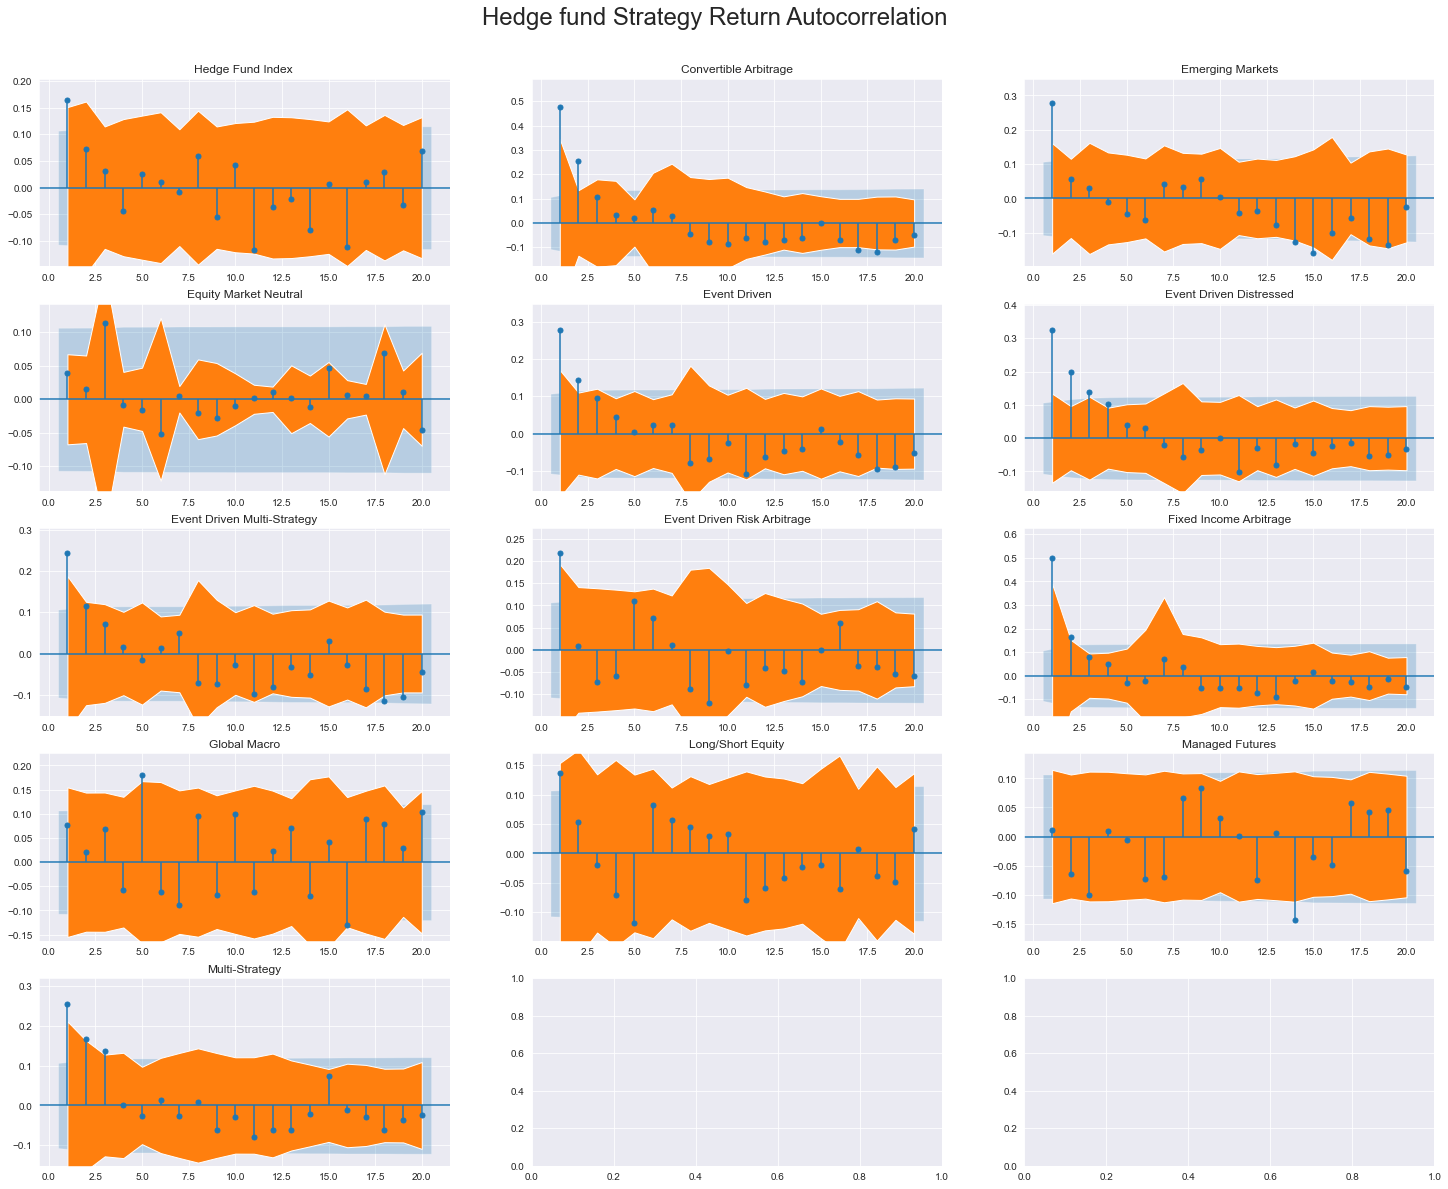

In [56]:
#autocorrelation
fig,ax = plt.subplots(5,3,figsize=(25,20))
row,col = 0, 0
for idx,strat in enumerate(hfd.columns):
    robust_std = np.zeros(21)
    robust_std[0]=np.nan
    for i in range(20):
        robust_std[i+1] = np.sqrt((hfd[strat].pow(2)*hfd[strat].shift(i+1).pow(2)).sum(skipna=True)/(hfd[strat].pow(2).sum()**2))
    sm.graphics.tsa.plot_acf(hfd[strat].values.squeeze(),ax = ax[row][col],lags=20,zero=False,auto_ylims=True,title=hfd_fullname[strat])
    ax[row][col].fill_between(np.arange(21), robust_std*2, -robust_std*2,label='Heteroskedastic robust confidence intervals')
    col +=1
    if col % 3 == 0:
        row += 1
        col = 0
plt.suptitle("Hedge fund Strategy Return Autocorrelation",y=0.93,fontsize=24)
plt.show()

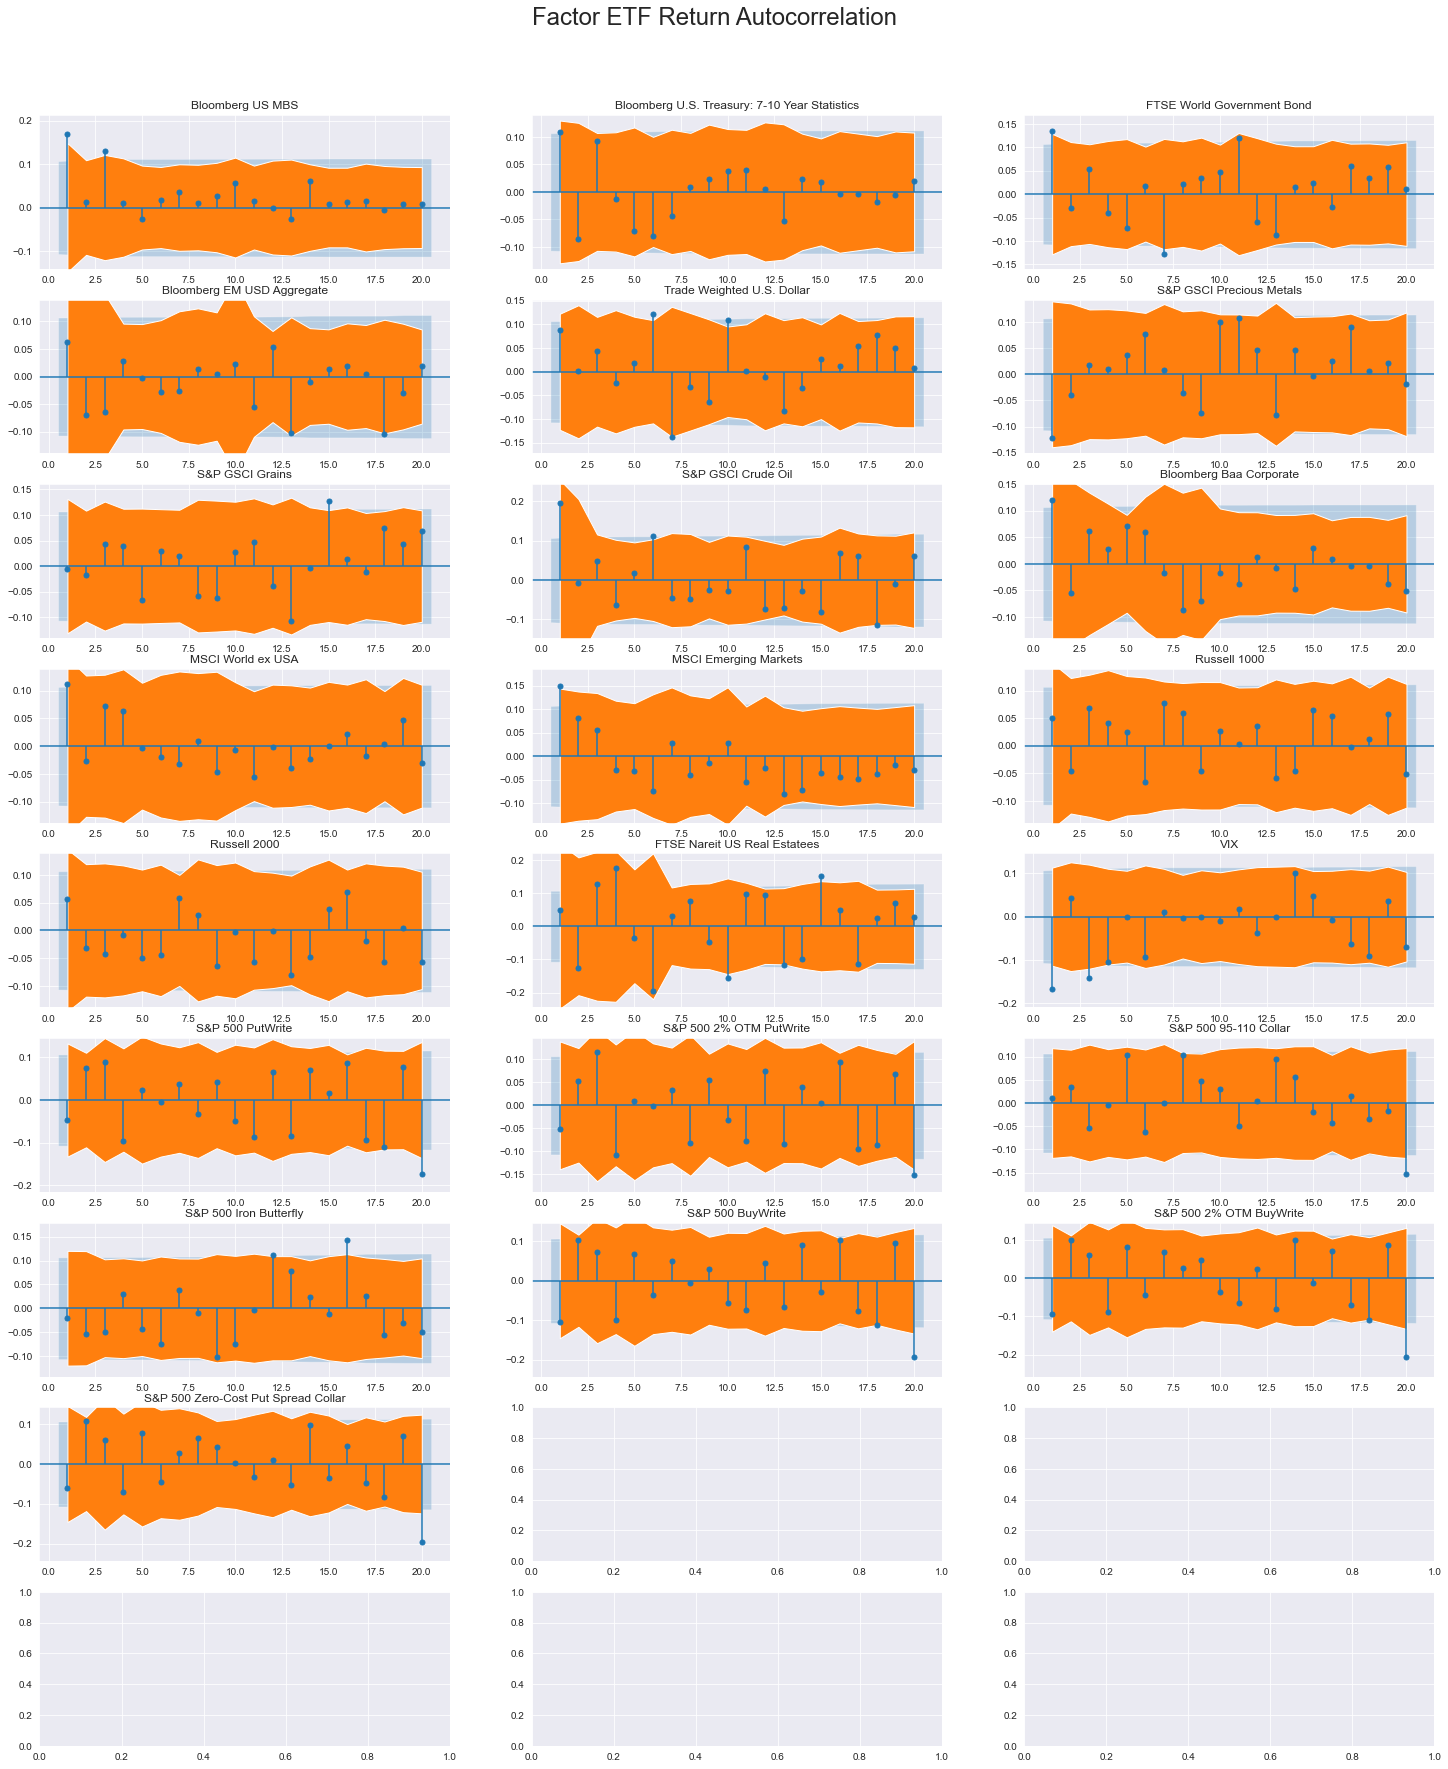

In [57]:
fig,ax = plt.subplots(9,3,figsize=(25,30))
row,col = 0, 0
for idx,strat in enumerate(factor_etf_data.columns):
    robust_std = np.zeros(21)
    robust_std[0]=np.nan
    for i in range(20):
        robust_std[i+1] = np.sqrt((factor_etf_data[strat].pow(2)*factor_etf_data[strat].shift(i+1).pow(2)).sum(skipna=True)/(factor_etf_data[strat].pow(2).sum()**2))
    sm.graphics.tsa.plot_acf(factor_etf_data[strat].values.squeeze(),ax = ax[row][col],lags=20,zero=False,auto_ylims=True,title=factor_etf_name[strat])
    ax[row][col].fill_between(np.arange(21), robust_std*2, -robust_std*2,label='Heteroskedastic robust confidence intervals')
    col +=1
    if col % 3 == 0:
        row += 1
        col = 0
plt.suptitle("Factor ETF Return Autocorrelation",y=0.93,fontsize=24)
plt.show()

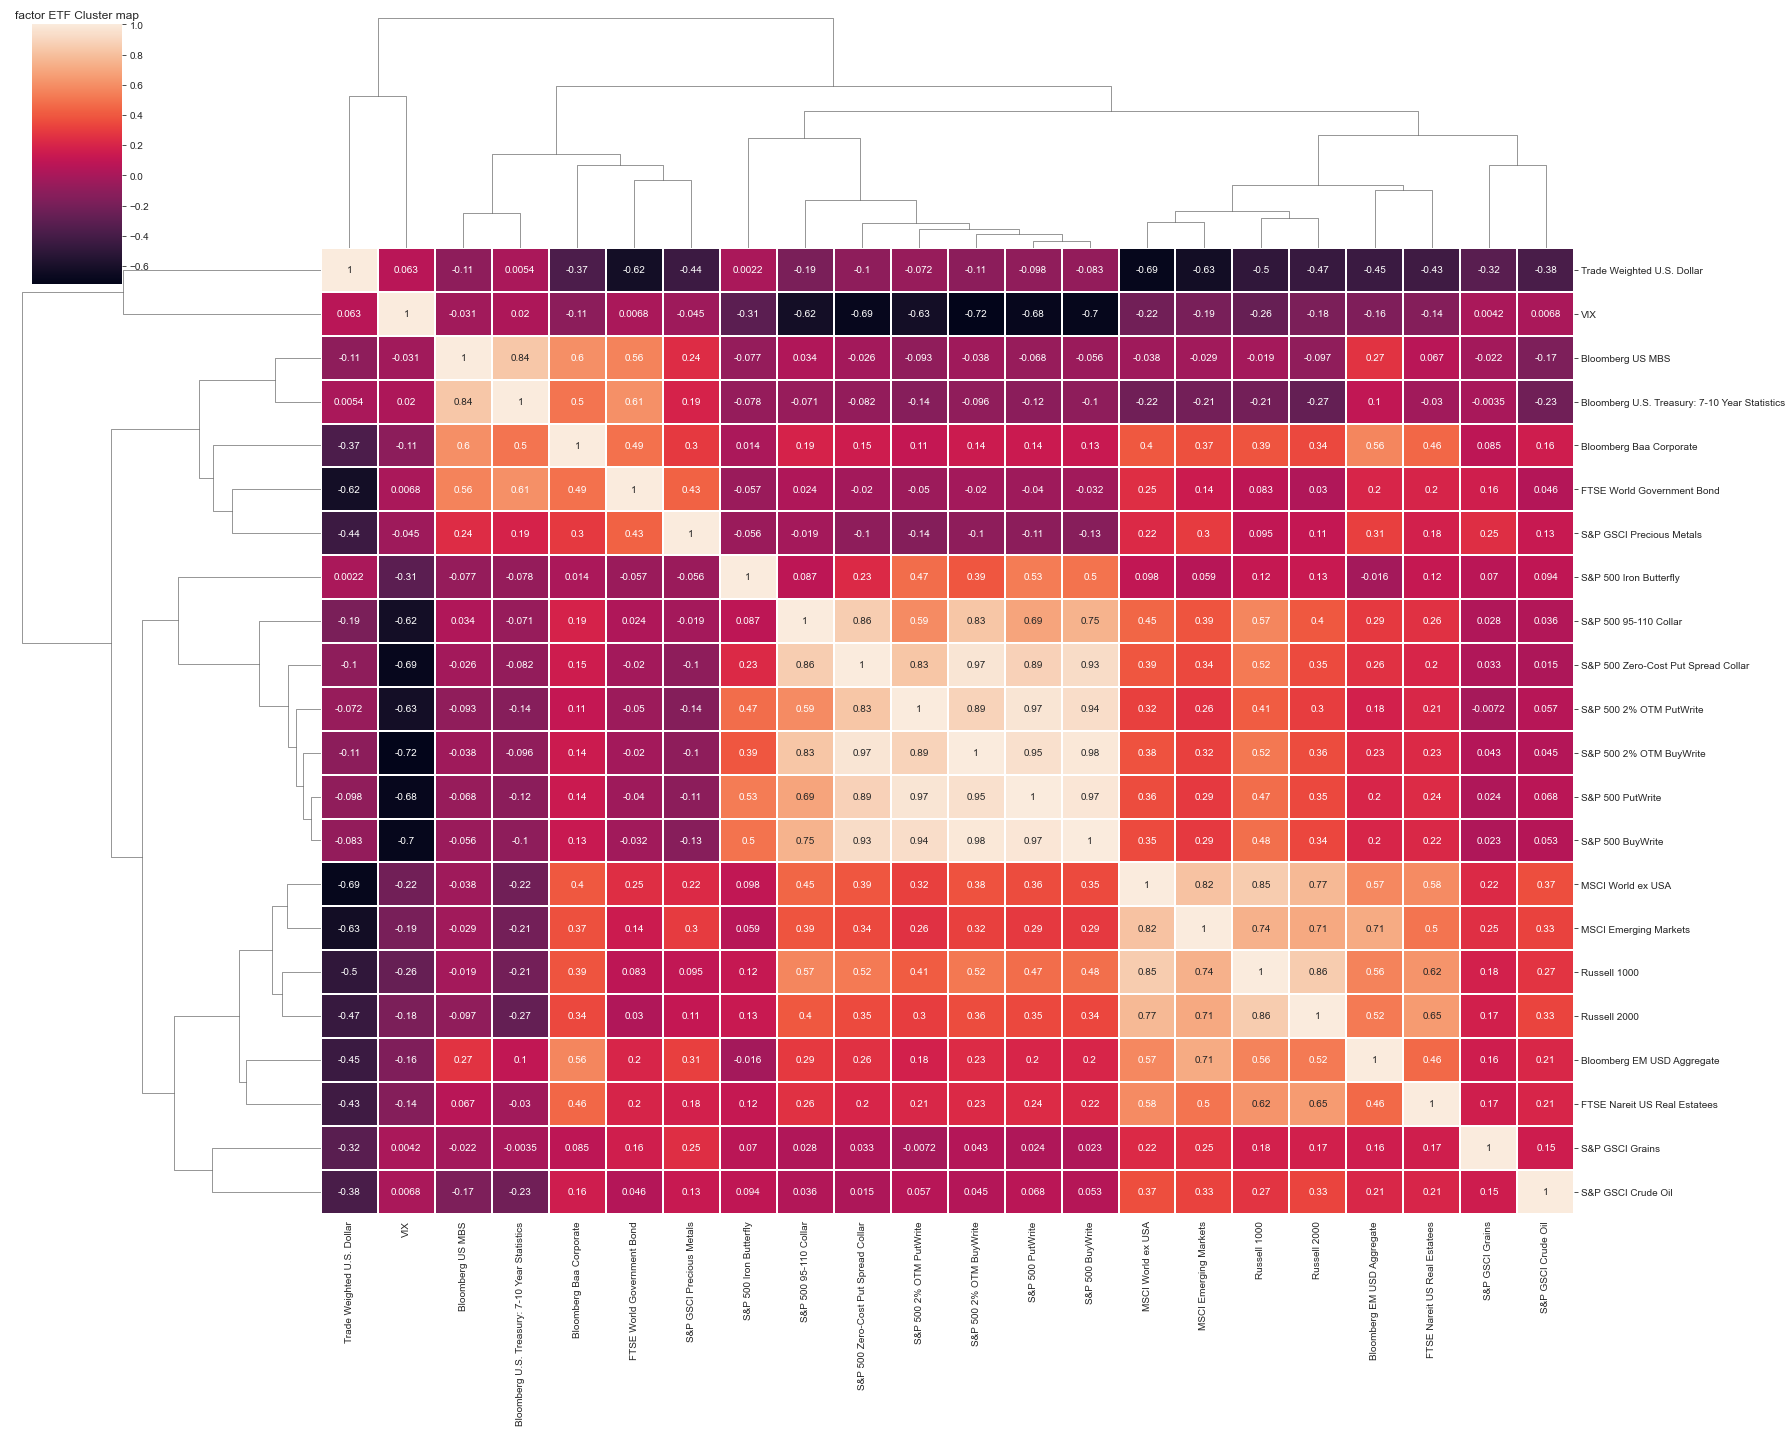

In [58]:
fig = sns.clustermap(factor_etf_data.rename(columns=factor_etf_name).corr(),annot = True,
                     annot_kws={"size": 10},  # Customize annotations
                     linewidths=0.4,
                     figsize=(25, 20),)
plt.setp(
    fig.ax_heatmap.xaxis.get_majorticklabels(),
    rotation=90,  # Change rotation of x-labels
)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('factor ETF Cluster map')
plt.show()

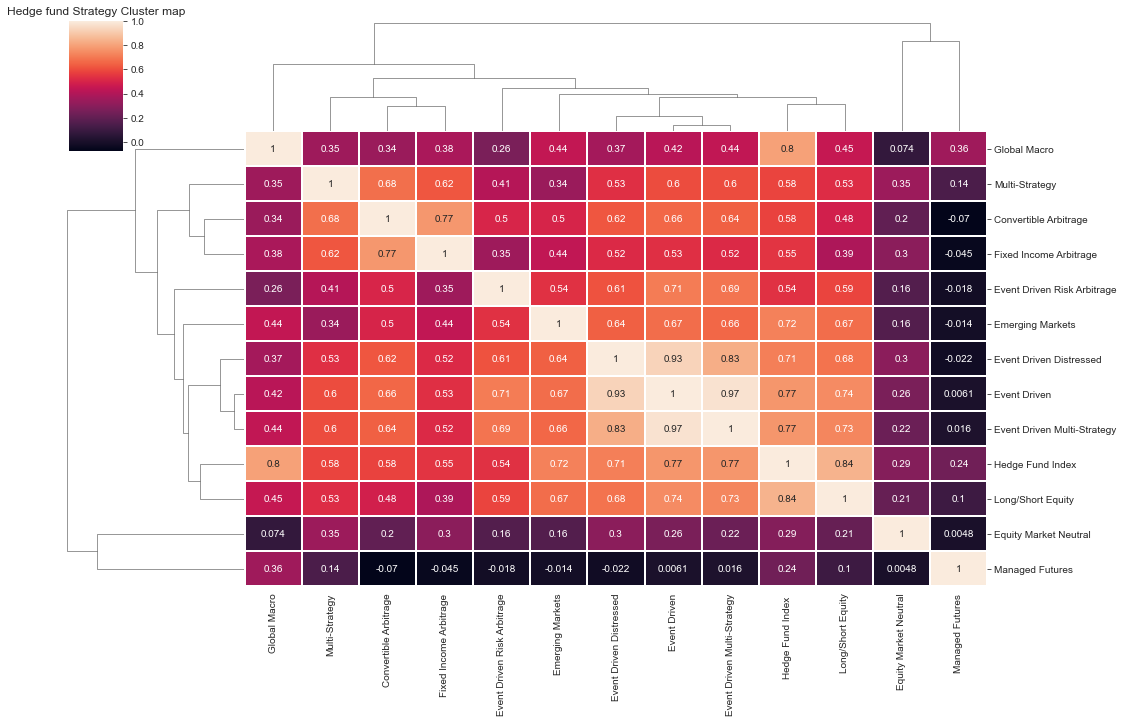

In [59]:
fig = sns.clustermap(hfd.rename(columns=hfd_fullname).corr(),annot = True,
                     annot_kws={"size": 10},  # Customize annotations
                     linewidths=0.4,
                     figsize=(15, 10),)

plt.setp(
    fig.ax_heatmap.xaxis.get_majorticklabels(),
    rotation=90,  # Change rotation of x-labels
)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Hedge fund Strategy Cluster map')
plt.show()

# Kitchen Sink Method

In [53]:
def OLS_beta(df, y_loc=-1, add_const=False):
    '''
    by assumption y is at the end of Dataframe
    :param df: composes of X and Y
    :param y_loc:
    :param add_const:
    :return:
    '''
    X = np.matrix(df.loc[:, df.columns != df.columns[y_loc]])
    Y = np.array(df.iloc[:, y_loc])
    if add_const:
        X = sm.add_constant(X)
    return np.linalg.pinv(X.T @ X) @ (X.T @ Y).T


def renormalization_factor(df, beta, window=24, y_loc=-1):
    X = np.matrix(df.loc[:, df.columns != df.columns[y_loc]])
    Y = np.array(df.iloc[:, y_loc])
    B = np.array(beta)
    rhat = B @ X.T
    #numerator
    neumerator = np.sqrt(np.sum(np.square(Y - np.mean(Y)) / (window - 1)))
    denominator = np.sqrt(np.sum(np.square(rhat - np.mean(rhat)) / (window - 1)))
    return neumerator / denominator


In [54]:
#rolling 24 month beta calculation
stepwise_ols_beta = []
window = 24
for strat in hfd.columns:
    '''
        ROLLING window
        window size 24
        i   start   end
        0     0      23
        1     1      24
        2     2      25
    '''
    strat_weight = []
    start, end = 0, window
    df_strat = factor_etf_data.join(hfd[strat])
    for i in range(len(df_strat) - window):
        df = df_strat.iloc[start: end]
        window_weight = OLS_beta(df).T.tolist()[0]  #OLS_beta in list
        normal_factor = renormalization_factor(df, window_weight)
        window_weight = [beta * normal_factor for beta in window_weight] #list of beta
        # delta weight on risk free asset required.
        window_weight.append(df.iloc[-1:].index[0])  #include final date of in-sample in first entry
        strat_weight.append(window_weight)
        #stepping forward
        start += 1
        end += 1
    col_name = factor_etf_data.columns.tolist()
    col_name.append('Date')
    strat_weight = pd.DataFrame(strat_weight, columns=col_name)
    strat_weight.set_index('Date', inplace=True)
    stepwise_ols_beta.append(strat_weight)


In [55]:
np.array(stepwise_ols_beta).shape

(13, 313, 22)

In [56]:
for strat_weight in stepwise_ols_beta:
    # Normalize so that the beta sum to one
    # strat_weight['sum'] = strat_weight.sum(axis=1)
    # for col in strat_weight.columns:
    #     strat_weight[col] /= strat_weight['sum']
    # del strat_weight['sum']
    # Shift the date with timedelta of 1
    strat_weight.index = hfd.index[24:]


In [57]:
OLS_ret = []
OOS_factor = factor_etf_data.iloc[window:]
OOS_rf = rf.iloc[window:]
for strat in stepwise_ols_beta:
    strat_ret = []
    for i in range(len(strat)):
        strat_ret.append(
            #minor issue: we dont know the leverage status because it is computed realtime
            OOS_rf.iloc[i].values[0] * (1 - np.sum(strat.iloc[i])) + np.sum(OOS_factor.iloc[i] * strat.iloc[i]))
    OLS_ret.append(strat_ret)

In [58]:
OLS_ret = pd.DataFrame(OLS_ret).T
OLS_ret.index = hfd.index[24:]
OLS_ret.columns = hfd.columns

In [59]:
OLS_ret

HEDG  HEDG_CVARB  HEDG_EMMKT  HEDG_EQNTR  HEDG_EVDRV  \
Date                                                                   
1996-04-30  0.021558    0.002660    0.041486    0.027105    0.010017   
1996-05-31  0.128148   -0.019413   -0.813997   -0.019142   -0.006036   
1996-06-30 -0.063618   -0.021889   -0.749303   -0.024718   -0.048518   
1996-07-31 -0.041163   -0.048401    0.025457    0.016481   -0.020484   
1996-08-31  0.083037   -0.032318   -0.088316   -0.084878    0.055444   
...              ...         ...         ...         ...         ...   
2021-12-31  0.018218   -0.015621    0.015262    0.016745    0.013275   
2022-01-31 -0.005539    0.020353    0.017422    0.007110   -0.004325   
2022-02-28 -0.008515    0.009395    0.035245    0.024300   -0.027096   
2022-03-31 -0.024867   -0.041102   -0.100600   -0.067513   -0.021934   
2022-04-30 -0.029516   -0.104723   -0.014660   -0.053885   -0.025164   

            HEDG_DISTR  HEDG_MSEVD  HEDG_MRARB  HEDG_FIARB  HEDG_GLMAC  \
Date                                                                     
1996-04-30    0.027267   -0.005386    0.000807    0.013441    0.022595   
1996-05-31    0.048682   -0.080446   -0.011174   -0.024675    0.283614   
1996-06-30   -0.052847   -0.049215   -0.061229   -0.028871   -0.025083   
1996-07-31   -0.038420    0.022338   -0.056220    0.012470   -0.043165   
1996-08-31    0.113548   -0.009823    0.025422    0.022829    0.113878   
...                ...         ...         ...         ...         ...   
2021-12-31    0.024954    0.011255    0.001313    0.002523    0.009916   
2022-01-31    0.005201   -0.005661   -0.032388    0.019003    0.003088   
2022-02-28    0.021616   -0.050709    0.064517   -0.036564   -0.054482   
2022-03-31    0.017629   -0.026505   -0.080195   -0.007986   -0.036749   
2022-04-30    0.115036   -0.083171    0.084723   -0.009910   -0.025626   

            HEDG_LOSHO  HEDG_MGFUT  HEDG_MULTI  
Date                                            
1996-04-30    0.021315    0.034601   -0.012685  
1996-05-31    0.028775    0.343586   -0.188016  
1996-06-30    0.018734   -0.012259   -0.071130  
1996-07-31   -0.087076    0.007519   -0.010074  
1996-08-31    0.028312    0.213516   -0.120889  
...                ...         ...         ...  
2021-12-31    0.039228    0.029388    0.010417  
2022-01-31   -0.032952   -0.012912    0.000033  
2022-02-28    0.030699    0.027078   -0.023511  
2022-03-31   -0.000526   -0.048911   -0.017827  
2022-04-30   -0.044125    0.093957   -0.062849  

[313 rows x 13 columns]

In [60]:
fig = px.line(OLS_ret.cumsum().rename(columns=hfd_fullname), title='Kitchen Sink Cumulative Return')
fig.show()

# Ex-ante Kitchen Sink Result

In [61]:
#tracking error
OOS_hfd = hfd.iloc[window:]+OOS_rf.values # hedge fund with rf
OLS_metrics=[]
for strat in OLS_ret.columns:
    metrics = [
        mean_squared_error(OOS_hfd[strat].cumsum(), OLS_ret[strat].cumsum(), squared=False),
        r2_score(OOS_hfd[strat].cumsum(),OLS_ret[strat].cumsum())
    ]
    OLS_metrics.append(metrics)

In [62]:
pd.DataFrame(OLS_metrics,columns=['RMSE','R2'],index=hfd_fullname.values())

RMSE         R2
Hedge Fund Index             0.567935  -0.532401
Convertible Arbitrage        0.657224  -1.401590
Emerging Markets             2.746070 -24.866050
Equity Market Neutral        0.486615  -2.790173
Event Driven                 0.422672   0.294037
Event Driven Distressed      0.477316   0.221350
Event Driven Multi-Strategy  0.402316   0.329801
Event Driven Risk Arbitrage  0.354027  -0.017242
Fixed Income Arbitrage       0.851900  -5.673875
Global Macro                 0.869037  -1.006683
Long/Short Equity            0.271230   0.731646
Managed Futures              1.473946 -16.767693
Multi-Strategy               0.921200  -2.381099

In [63]:
OLS_ret

HEDG  HEDG_CVARB  HEDG_EMMKT  HEDG_EQNTR  HEDG_EVDRV  \
Date                                                                   
1996-04-30  0.021558    0.002660    0.041486    0.027105    0.010017   
1996-05-31  0.128148   -0.019413   -0.813997   -0.019142   -0.006036   
1996-06-30 -0.063618   -0.021889   -0.749303   -0.024718   -0.048518   
1996-07-31 -0.041163   -0.048401    0.025457    0.016481   -0.020484   
1996-08-31  0.083037   -0.032318   -0.088316   -0.084878    0.055444   
...              ...         ...         ...         ...         ...   
2021-12-31  0.018218   -0.015621    0.015262    0.016745    0.013275   
2022-01-31 -0.005539    0.020353    0.017422    0.007110   -0.004325   
2022-02-28 -0.008515    0.009395    0.035245    0.024300   -0.027096   
2022-03-31 -0.024867   -0.041102   -0.100600   -0.067513   -0.021934   
2022-04-30 -0.029516   -0.104723   -0.014660   -0.053885   -0.025164   

            HEDG_DISTR  HEDG_MSEVD  HEDG_MRARB  HEDG_FIARB  HEDG_GLMAC  \
Date                                                                     
1996-04-30    0.027267   -0.005386    0.000807    0.013441    0.022595   
1996-05-31    0.048682   -0.080446   -0.011174   -0.024675    0.283614   
1996-06-30   -0.052847   -0.049215   -0.061229   -0.028871   -0.025083   
1996-07-31   -0.038420    0.022338   -0.056220    0.012470   -0.043165   
1996-08-31    0.113548   -0.009823    0.025422    0.022829    0.113878   
...                ...         ...         ...         ...         ...   
2021-12-31    0.024954    0.011255    0.001313    0.002523    0.009916   
2022-01-31    0.005201   -0.005661   -0.032388    0.019003    0.003088   
2022-02-28    0.021616   -0.050709    0.064517   -0.036564   -0.054482   
2022-03-31    0.017629   -0.026505   -0.080195   -0.007986   -0.036749   
2022-04-30    0.115036   -0.083171    0.084723   -0.009910   -0.025626   

            HEDG_LOSHO  HEDG_MGFUT  HEDG_MULTI  
Date                                            
1996-04-30    0.021315    0.034601   -0.012685  
1996-05-31    0.028775    0.343586   -0.188016  
1996-06-30    0.018734   -0.012259   -0.071130  
1996-07-31   -0.087076    0.007519   -0.010074  
1996-08-31    0.028312    0.213516   -0.120889  
...                ...         ...         ...  
2021-12-31    0.039228    0.029388    0.010417  
2022-01-31   -0.032952   -0.012912    0.000033  
2022-02-28    0.030699    0.027078   -0.023511  
2022-03-31   -0.000526   -0.048911   -0.017827  
2022-04-30   -0.044125    0.093957   -0.062849  

[313 rows x 13 columns]

In [66]:
#data analysis
np.round(data_analysis(OLS_ret,hfd_fullname.values(),start = '1996-04-30',end='2022-04-30',span=factor_etf_data),3)

Skewness  Kurtosis  Omega_ratio(0%)  \
Hedge Fund Index                1.016     6.415            1.479   
Convertible Arbitrage           0.020     3.625            1.473   
Emerging Markets               -2.065    19.159            0.887   
Equity Market Neutral          -2.003    36.196            0.993   
Event Driven                   -0.401     4.034            1.453   
Event Driven Distressed         0.427     5.495            1.566   
Event Driven Multi-Strategy    -0.623     5.596            1.346   
Event Driven Risk Arbitrage    -0.686     6.017            1.206   
Fixed Income Arbitrage         -2.982    18.446            0.940   
Global Macro                    1.586    13.294            1.368   
Long/Short Equity               1.151    12.175            1.357   
Managed Futures                -0.128     5.832            1.020   
Multi-Strategy                 -0.875     6.964            1.066   

                             Omega_ratio(10%)  cVaR(95%)  CEQ Gamma=2  \
Hedge Fund Index                        1.021     -0.105        0.046   
Convertible Arbitrage                   1.007     -0.107        0.048   
Emerging Markets                        0.729     -0.333       -0.416   
Equity Market Neutral                   0.782     -0.296       -2.824   
Event Driven                            1.006     -0.119        0.045   
Event Driven Distressed                 1.117     -0.124        0.061   
Event Driven Multi-Strategy             0.960     -0.134        0.028   
Event Driven Risk Arbitrage             0.765     -0.097        0.010   
Fixed Income Arbitrage                  0.588     -0.144       -0.043   
Global Macro                            1.073     -0.183        0.009   
Long/Short Equity                       0.980     -0.128        0.026   
Managed Futures                         0.899     -0.347       -0.348   
Multi-Strategy                          0.709     -0.118       -0.015   

                             CEQ Gamma=5  CEQ Gamma=10  Annualized_Sharpe  \
Hedge Fund Index                   0.003        -0.072              0.433   
Convertible Arbitrage              0.008        -0.066              0.461   
Emerging Markets                  -4.674       -12.612             -0.110   
Equity Market Neutral            -35.008       -44.585             -0.005   
Event Driven                      -0.002        -0.096              0.439   
Event Driven Distressed            0.006        -0.097              0.509   
Event Driven Multi-Strategy       -0.033        -0.172              0.346   
Event Driven Risk Arbitrage       -0.023        -0.092              0.215   
Fixed Income Arbitrage            -0.117        -0.397             -0.059   
Global Macro                      -0.132        -0.549              0.313   
Long/Short Equity                 -0.037        -0.167              0.328   
Managed Futures                   -2.380        -8.420              0.022   
Multi-Strategy                    -0.059        -0.164              0.073   

                             FF3F_alpha  FF5F_alpha  GRS_testF  HK_testF  \
Hedge Fund Index                  0.004       0.004      1.071     0.962   
Convertible Arbitrage             0.005       0.005      1.066     3.058   
Emerging Markets                 -0.007      -0.007      0.337     0.178   
Equity Market Neutral            -0.002      -0.002      0.003     0.475   
Event Driven                      0.004       0.004      2.507     8.783   
Event Driven Distressed           0.006       0.006      7.017     9.127   
Event Driven Multi-Strategy       0.004       0.004      0.568     6.078   
Event Driven Risk Arbitrage       0.002       0.002      0.481     8.379   
Fixed Income Arbitrage           -0.002      -0.002      0.347     1.382   
Global Macro                      0.006       0.006      0.177     0.539   
Long/Short Equity                 0.002       0.002      0.356     1.029   
Managed Futures                  -0.001      -0.001      0.489

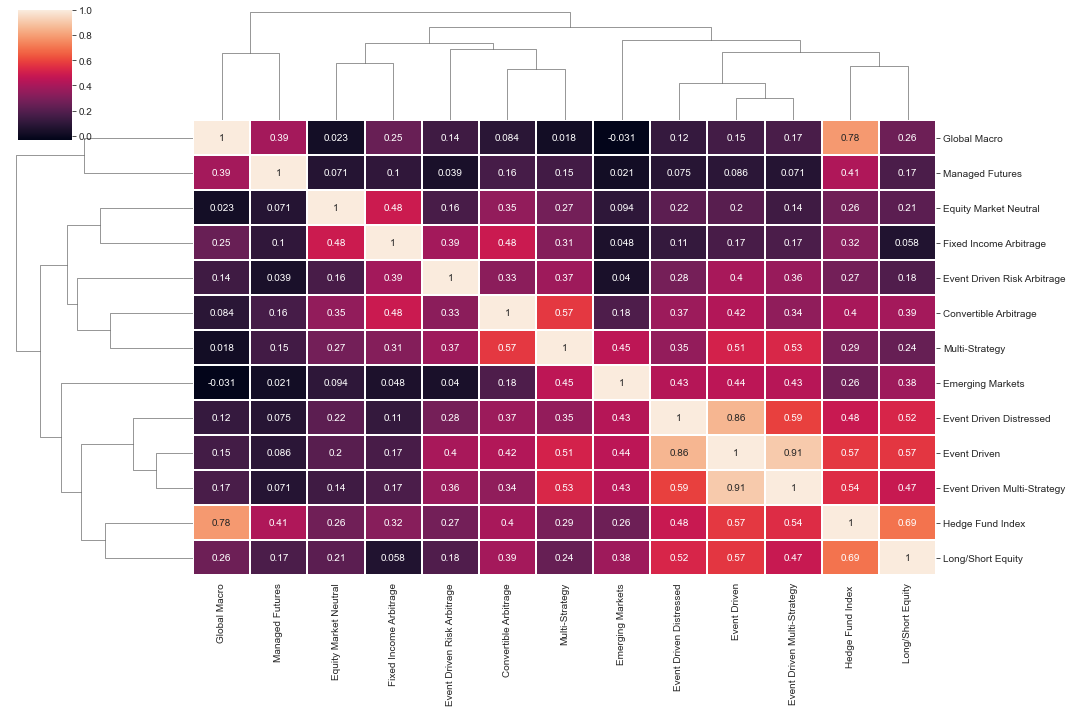

In [72]:
fig = sns.clustermap(OLS_ret.rename(columns=hfd_fullname).corr(),annot = True,
                     annot_kws={"size": 10},  # Customize annotations
                     linewidths=0.4,
                     figsize=(15, 10),)

plt.setp(
    fig.ax_heatmap.xaxis.get_majorticklabels(),
    rotation=90,  # Change rotation of x-labels
)
plt.rcParams['figure.facecolor'] = 'white'
plt.show()

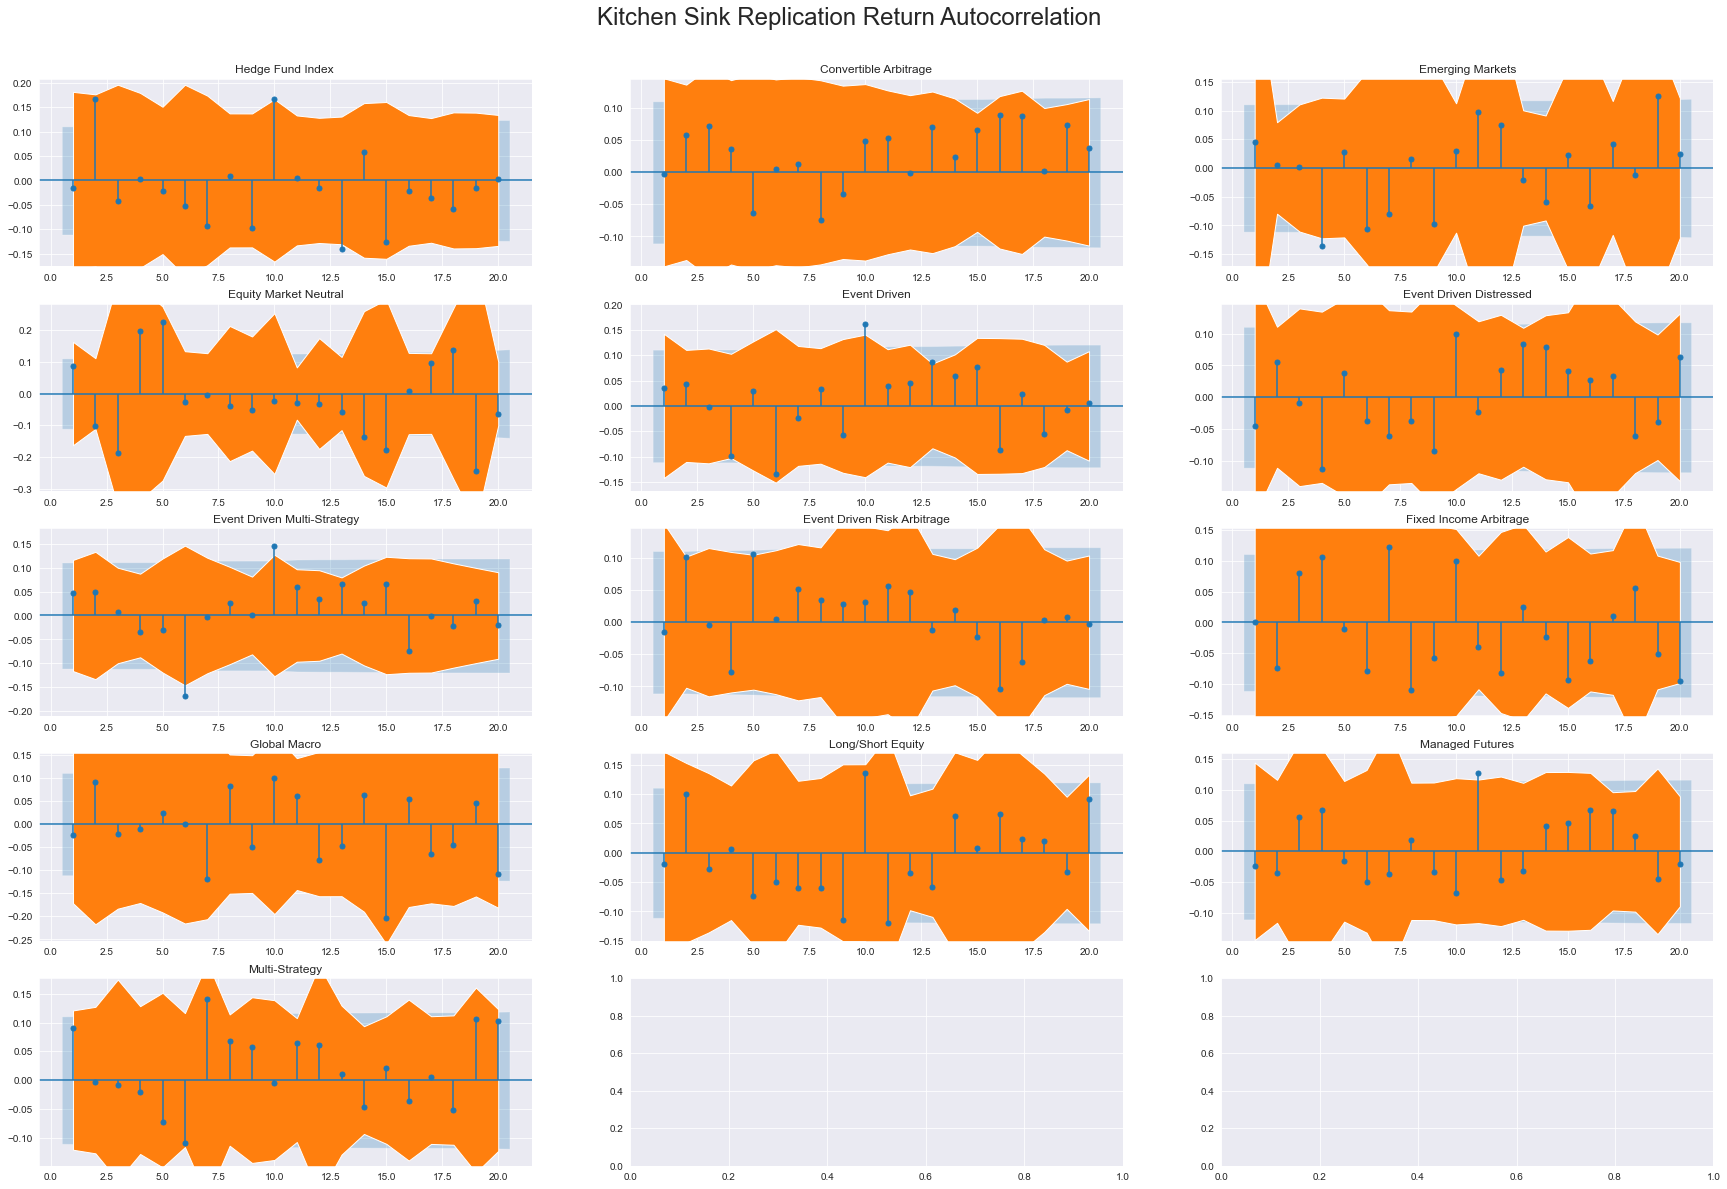

In [73]:
#autocorrelation
fig,ax = plt.subplots(5,3,figsize=(30,20))
row,col = 0, 0
for idx,strat in enumerate(OLS_ret.columns):
    robust_std = np.zeros(21)
    robust_std[0]=np.nan
    for i in range(20):
        robust_std[i+1] = np.sqrt((OLS_ret[strat].pow(2)*OLS_ret[strat].shift(i+1).pow(2)).sum(skipna=True)/(OLS_ret[strat].pow(2).sum()**2))
    sm.graphics.tsa.plot_acf(OLS_ret[strat].values.squeeze(),ax = ax[row][col],lags=20,zero=False,auto_ylims=True,title=hfd_fullname[strat])
    ax[row][col].fill_between(np.arange(21), robust_std*2, -robust_std*2,label='Heteroskedastic robust confidence intervals')
    col +=1
    if col % 3 == 0:
        row += 1
        col = 0
plt.suptitle("Kitchen Sink Replication Return Autocorrelation",y=0.93,fontsize=24)
plt.show()

# Ex-post transaction cost and pricing impact

In [97]:
#simple annualized turnover calculation
for i in range(len(stepwise_ols_beta)):
    print(list(hfd_fullname.values())[i],np.round(abs(stepwise_ols_beta[i].diff()).sum().sum()/(len(stepwise_ols_beta[i])/12),3))#annual turnover

Hedge Fund Index  176.97
Convertible Arbitrage 198.991
Emerging Markets 366.313
Equity Market Neutral 296.547
Event Driven 193.144
Event Driven Distressed 203.727
Event Driven Multi-Strategy 209.542
Event Driven Risk Arbitrage 154.559
Fixed Income Arbitrage 147.578
Global Macro 298.862
Long/Short Equity 184.367
Managed Futures 614.587
Multi-Strategy 191.037


In [75]:
from frds.measures import kyle_lambda

In [76]:
volumes = np.array(
    [[100, 180, 900, 970, 430, 110], [200, 250, 400, 590, 260, 600], [300, 700, 220, 110, 290, 310]]
)
price =  np.array(
    [[44, 39, 36, 28, 23, 18], [82, 81, 79, 40, 26, 13], [55, 67, 13, 72, 10, 65]]
)

In [77]:
price

array([[44, 39, 36, 28, 23, 18],
       [82, 81, 79, 40, 26, 13],
       [55, 67, 13, 72, 10, 65]])

In [78]:
volumes

array([[100, 180, 900, 970, 430, 110],
       [200, 250, 400, 590, 260, 600],
       [300, 700, 220, 110, 290, 310]])

In [79]:
kyle_lambda(price,volumes)

array([-0.02198189, -0.1951004 ,  0.22752204])

Assume transaction cost and pricing impact is proportional to asset volatility
implementation of Multi-Period Portfolio Optimization example 3

In [80]:
np.diag(np.matrix(factor_etf_data.iloc[:24].cov()))

array([0.00011183, 0.00016084, 0.00031122, 0.00219963, 0.00019305,
       0.00051265, 0.00160637, 0.00493836, 0.00024106, 0.00091606,
       0.00250514, 0.00047984, 0.00077591, 0.00070092, 0.06566198,
       0.0003547 , 0.0001742 , 0.00079495, 0.00066916, 0.00046414,
       0.00075612, 0.0004918 ])

In [68]:
def transaction_cost(old_x,new_x,covMatrix,param=0.05):
    '''

    :param new_x:
    :param old_x:
    :param covMatrix: asset covariance
    :param param: transaction parameters
    :return:
    '''
    isinstance(param,float)
    covMatrix = np.sqrt(np.diag(np.matrix(covMatrix))) * param
    old_x = np.array(old_x)
    new_x = np.array(new_x)
    delta_x = old_x-new_x

    return 0.5 * delta_x**2 * covMatrix


def price_impact(old_x,new_x,covMatrix,param=0.05,phi=0.5):
    isinstance(param,float)
    isinstance(phi,float)

    covMatrix = np.sqrt(np.diag(np.matrix(covMatrix))) * param
    old_x = np.array(old_x)
    new_x = np.array(new_x)
    delta_x = old_x-new_x

    return phi * new_x * covMatrix * delta_x - old_x * covMatrix * delta_x - 0.5 * delta_x**2 * covMatrix



In [69]:
#ex-post return
window = 24
OLS_ret_ex_post=[]
for idx in range(len(OLS_ret.columns)):
    strat_penalty = []
    # strat_tc = []
    # strat_pi=[]
    strat_ex_post=[]
    strat_ex_post.append(OLS_ret.iloc[:,idx][0])
    for i in range(1,len(factor_etf_data)-window):
        cov_matrix = factor_etf_data.iloc[i:i+window].cov()
        new_x = stepwise_ols_beta[idx].iloc[i]
        old_x = stepwise_ols_beta[idx].iloc[i-1]

        tc = transaction_cost(old_x,new_x,cov_matrix)
        pi=price_impact(old_x,new_x,cov_matrix)
        penalty = tc+pi
        # strat_tc.append(tc.sum())
        # strat_pi.append(pi.sum())
        strat_penalty.append(penalty.sum())
    for i in range(1,len(OLS_ret)):
        strat_ex_post.append(OLS_ret.iloc[:,idx][i]+strat_penalty[i-1])
    OLS_ret_ex_post.append(strat_ex_post)

In [70]:
OLS_ret_ex_post = pd.DataFrame(OLS_ret_ex_post,columns=OLS_ret.index,index=OLS_ret.columns).T

In [72]:
np.round(data_analysis(OLS_ret_ex_post,hfd_fullname.values(),start = '1996-04-30',end='2022-04-30',span=factor_etf_data),3)

C:\Users\kevin\AppData\Local\Temp/ipykernel_17772/2212952401.py:76: RuntimeWarning:

invalid value encountered in log



Skewness  Kurtosis  Omega_ratio(0%)  \
Hedge Fund Index               -8.461    93.031            0.201   
Convertible Arbitrage         -12.687   187.361            0.151   
Emerging Markets              -14.512   231.716            0.034   
Equity Market Neutral         -13.634   202.722            0.048   
Event Driven                   -7.602    68.581            0.206   
Event Driven Distressed        -8.620    83.220            0.167   
Event Driven Multi-Strategy    -5.194    36.985            0.199   
Event Driven Risk Arbitrage    -6.333    60.788            0.247   
Fixed Income Arbitrage        -12.115   174.228            0.141   
Global Macro                   -5.222    30.640            0.091   
Long/Short Equity              -3.272    19.051            0.236   
Managed Futures                -6.080    46.252            0.036   
Multi-Strategy                 -6.420    49.064            0.114   

                             Omega_ratio(10%)  cVaR(95%)  CEQ Gamma=2  \
Hedge Fund Index                        0.150     -0.569        2.460   
Convertible Arbitrage                   0.115     -0.804       -0.211   
Emerging Markets                        0.029     -6.078       -9.899   
Equity Market Neutral                   0.045    -10.681        0.474   
Event Driven                            0.159     -0.632       -0.263   
Event Driven Distressed                 0.134     -0.969       -0.311   
Event Driven Multi-Strategy             0.156     -0.597       -1.980   
Event Driven Risk Arbitrage             0.176     -0.348       -0.215   
Fixed Income Arbitrage                  0.099     -0.794       -0.232   
Global Macro                            0.077     -1.789        0.189   
Long/Short Equity                       0.182     -0.408       -2.018   
Managed Futures                         0.033     -6.058       -2.573   
Multi-Strategy                          0.084     -0.883        0.197   

                             CEQ Gamma=5  CEQ Gamma=10  Annualized_Sharpe  \
Hedge Fund Index                 -32.725           NaN             -0.808   
Convertible Arbitrage             -4.543           NaN             -0.646   
Emerging Markets                 -54.039       -63.616             -0.460   
Equity Market Neutral            -10.082           NaN             -0.369   
Event Driven                      -1.118        -3.488             -0.814   
Event Driven Distressed           -1.887        -7.071             -0.686   
Event Driven Multi-Strategy      -25.092       -34.274             -1.064   
Event Driven Risk Arbitrage       -3.054           NaN             -0.969   
Fixed Income Arbitrage            -1.603        -4.350             -0.608   
Global Macro                      -6.783           NaN             -1.030   
Long/Short Equity                -27.289       -36.865             -1.172   
Managed Futures                  -29.113       -38.354             -1.158   
Multi-Strategy                    -4.180           NaN             -0.911   

                             FF3F_alpha  FF5F_alpha  GRS_testF  HK_testF  \
Hedge Fund Index                 -0.043      -0.043     10.901     6.472   
Convertible Arbitrage            -0.054      -0.054      6.069     5.208   
Emerging Markets                 -0.372      -0.373      2.642     1.384   
Equity Market Neutral            -0.487      -0.485      2.534     2.185   
Event Driven                     -0.047      -0.047     10.289     8.284   
Event Driven Distressed          -0.064      -0.064      6.959     4.777   
Event Driven Multi-Strategy      -0.051      -0.051     17.897    12.963   
Event Driven Risk Arbitrage      -0.029      -0.029     11.943     7.810   
Fixed Income Arbitrage           -0.047      -0.047      6.692     5.507   
Global Macro                     -0.140      -0.140     20.021    10.229   
Long/Short Equity                -0.042      -0.042     27.192    14.839   
Managed Futures                  -0.517      -0.517     21.261

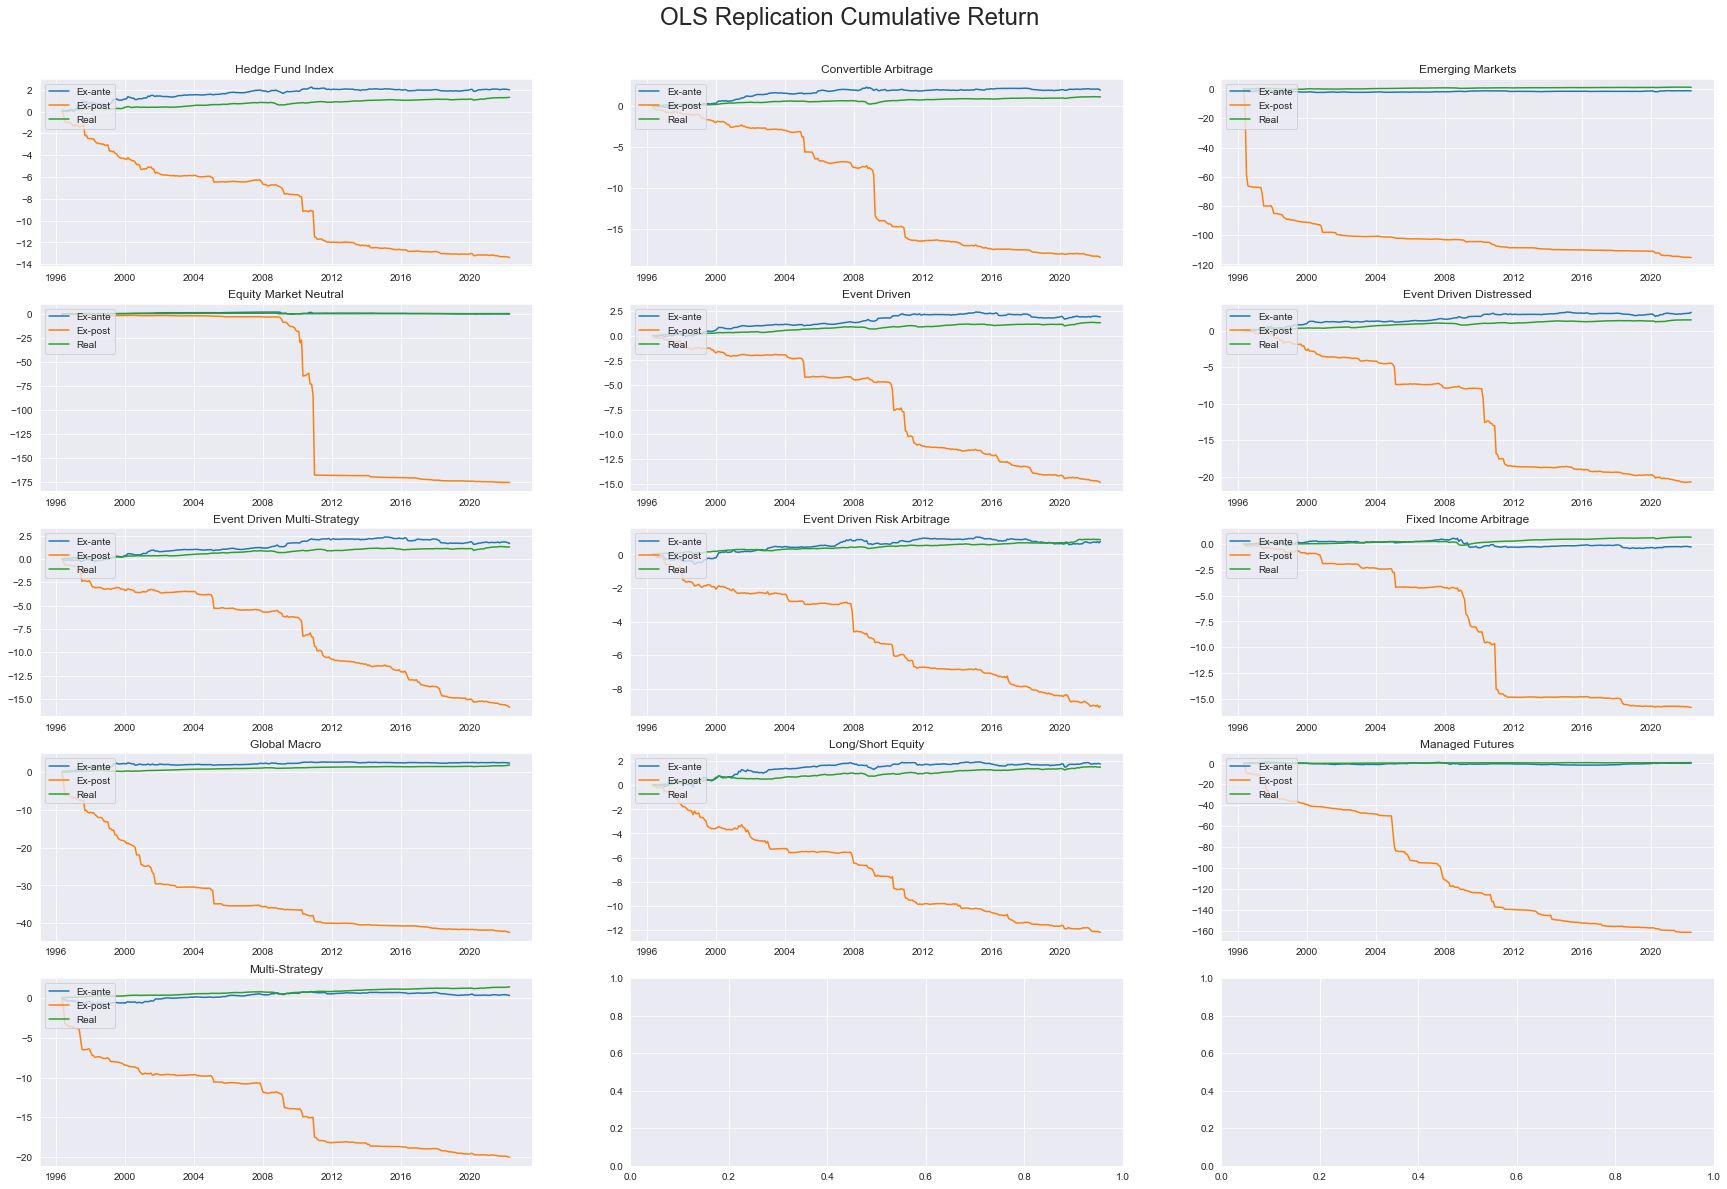

In [95]:
fig,ax = plt.subplots(5,3,figsize=(30,20))
row,col = 0, 0
for idx,strat in enumerate(OLS_ret.columns):
    temp = pd.DataFrame([OLS_ret.iloc[:,idx].cumsum(),OLS_ret_ex_post.iloc[:,idx].cumsum(),hfd.iloc[24: ,idx].cumsum()],index=['Ex-ante','Ex-post','Real']).T
    for i,name in enumerate(temp.columns):
        ax[row][col].plot(temp.iloc[:,i],label = name)
        ax[row][col].legend(loc="upper left")
    ax[row][col].set_title(hfd_fullname[strat])
    col +=1
    if col % 3 == 0:
        row += 1
        col = 0
plt.suptitle("OLS Replication Cumulative Return",y=0.93,fontsize=24)
plt.show()

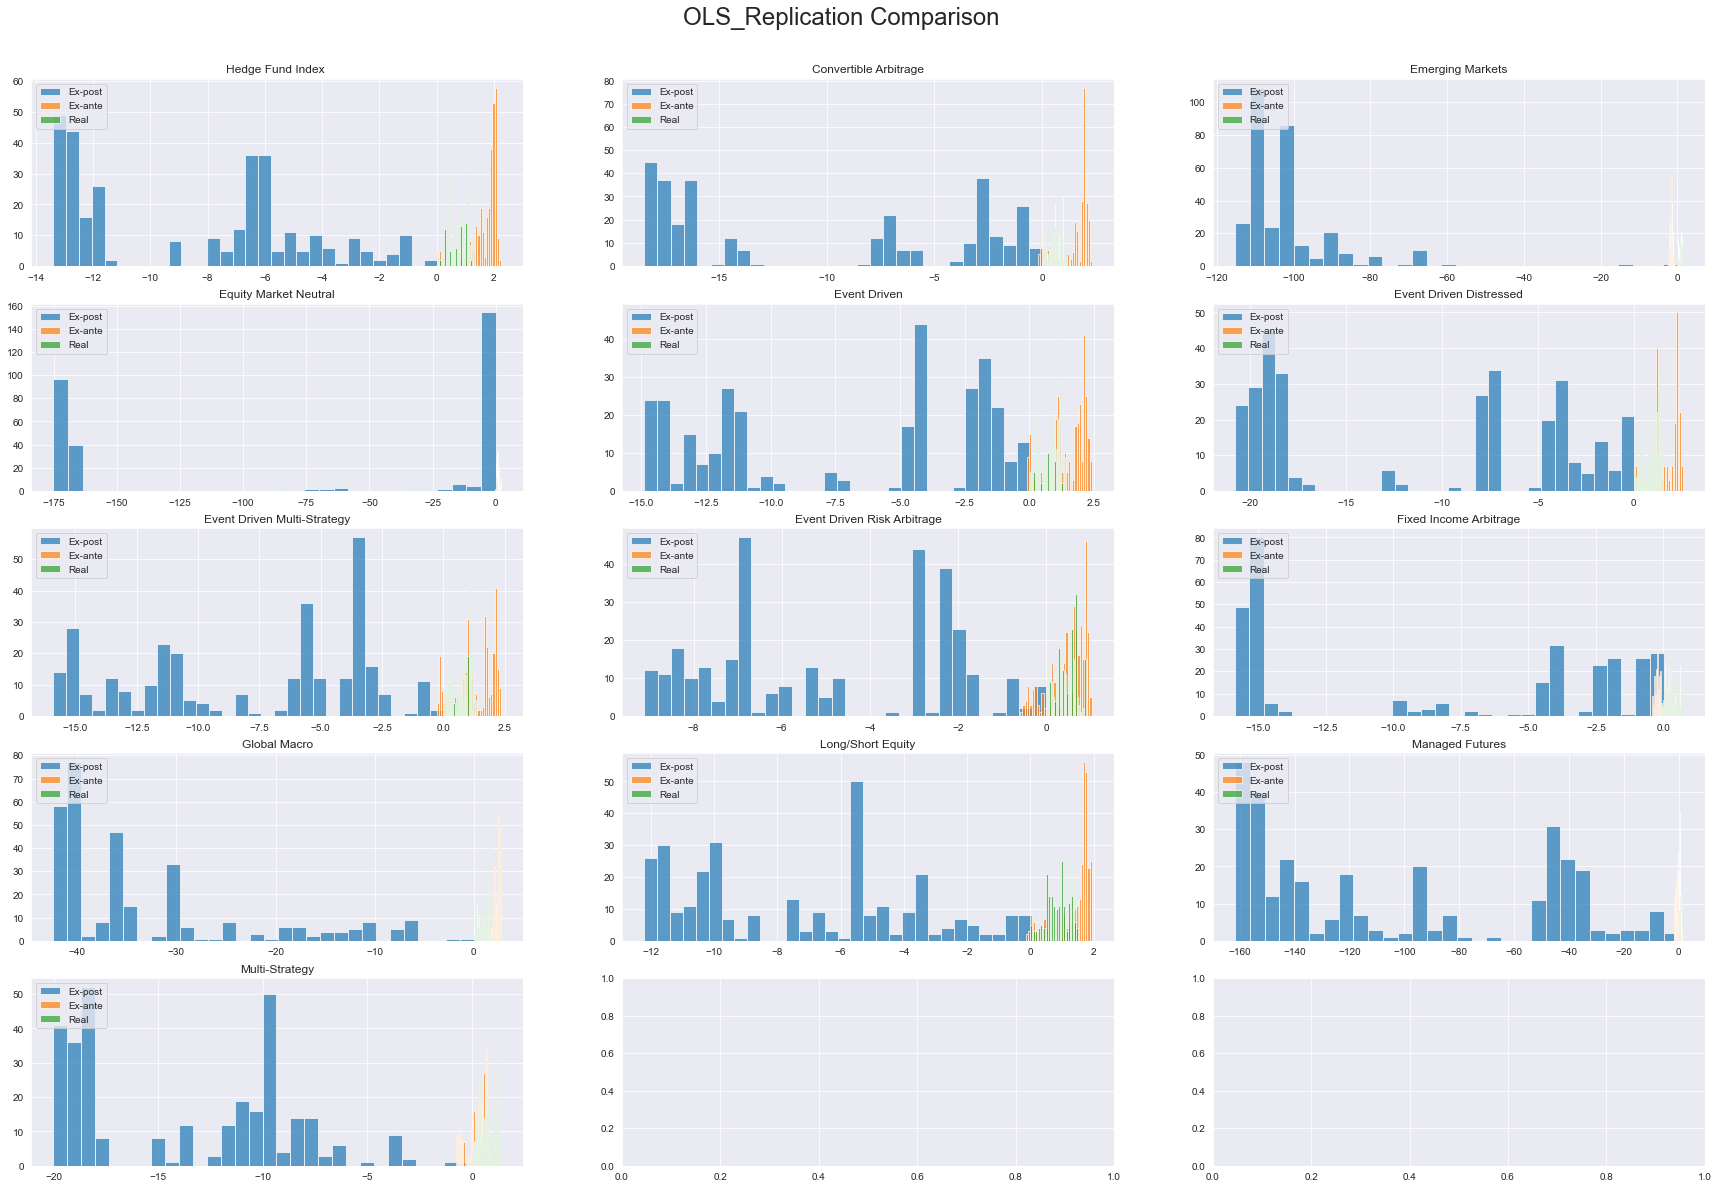

In [85]:
fig,ax = plt.subplots(5,3,figsize=(30,20))
row,col = 0, 0
for idx,strat in enumerate(OLS_ret.columns):
    temp = pd.DataFrame([OLS_ret_ex_post.iloc[:,idx].cumsum(),OLS_ret.iloc[:,idx].cumsum(),hfd.iloc[24: ,idx].cumsum()],index=['Ex-post','Ex-ante','Real']).T
    for i,name in enumerate(temp.columns):
        ax[row][col].hist(temp.iloc[:,i],label = name,bins=30,alpha=0.7)
        ax[row][col].legend(loc="upper left")
    ax[row][col].set_title(hfd_fullname[strat])
    col +=1
    if col % 3 == 0:
        row += 1
        col = 0
plt.suptitle("OLS_Replication Comparison",y=0.93,fontsize=24)
plt.show()

# OLS with HK test

In [73]:
def padding(position, data,length):
    isinstance(position,list)
    isinstance(data,list)
    # assert len(position) == len(data)
    res = [0]*length
    for idx,num in enumerate(position):
        res[num]=data[idx]
    return res

def efficient_span(df,method='HK'):
    '''

    :param method:
    :param df:
    :return: list of position of the factor that span the mean-variance frontier
    '''
    full_factor=df.columns.tolist()
    best_span = []
    for i in range(len(full_factor)-1):
        span = full_factor[i:i+1]
        remain = [factor for factor in full_factor if factor not in span]
        while remain:
            significance=np.inf
            best_factor = str()
            for new_asset in remain:
                if method == 'HK':
                    cur = hktest(np.array(df.loc[:,new_asset]),np.array(df.loc[:,span]))[1]
                elif method == 'GRS':
                    cur = grstest(np.array(df.loc[:,new_asset]),np.array(df.loc[:,span]))[1]
                else:
                    raise Exception('Does not supprot tests other than HK or GRS')
                if cur<significance:
                    significance,best_factor = cur,new_asset
            if significance<0.05:
                span.append(best_factor)
                remain.remove(best_factor)
                # print(f"portfolio:{span}")
                # print(f"remain num of asset:{len(remain)}")
            else:
                # print('finished')
                best_span.append(span)
                break
    # evaluate sharpe of each span by mean variance optimizaton
    best_span_idx=int()
    best_sharpe = -np.inf
    flag=False
    for idx,span in enumerate(best_span):
        mu = mean_historical_return(df.loc[:,span],returns_data=True,frequency=12)
        S = sample_cov(df.loc[:,span],returns_data=True,frequency=12)
        ef = EfficientFrontier(mu,S)
        try:
            weights = ef.max_sharpe()
        except:
            # print(f'warning: {span} no optimization result, skipped.')
            flag = True
            break
        if ef.portfolio_performance()[2]>best_sharpe:
            best_sharpe = ef.portfolio_performance()[2]
            best_span_idx = idx
    if flag:
        #min-length
        min_len = np.inf
        min_len_idx=int()
        for idx,span in enumerate(best_span):
            if len(span)<min_len:
                min_len_idx,min_len = idx,len(span)
        best_span_idx = min_len_idx
        print('no optimization result for all span, picked min-length')
    span_idx_list=[]
    for factor in best_span[best_span_idx]:
        span_idx_list.append(full_factor.index(factor))
    return span_idx_list,best_span[best_span_idx]


In [74]:
import time
window = 24
start_t = time.time()
#first calculate factor span for all window, so we avoid doing so for every strategy
span_idx_list=[]
span_factor_list = []
start, end = 0, window
for i in range(len(factor_etf_data)-window):
    idx,factor = efficient_span(factor_etf_data.iloc[start:end,])
    span_idx_list.append(idx)
    span_factor_list.append(factor)
    start+=1
    end+=1
    if i % 10==0:
        print(f'{i+1} out of 313 done')
end_t=time.time()
print(end_t-start_t)# 6min

1 out of 313 done
11 out of 313 done
no optimization result for all span, picked min-length


C:\python\lib\site-packages\cvxpy\problems\problem.py:1296: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



no optimization result for all span, picked min-length
21 out of 313 done
31 out of 313 done
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
41 out of 313 done
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
51 out of 313 done
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
61 out of 313 done
no optimization result for all span, picked min-length
no optimization result for all span, picked min-length
no optimization result fo

In [78]:
factor_etf_data.iloc[:24,].loc[:,span_factor_list[0]]

VIX      PUTY       PUT     TWEXB       CLL  SPGSCI_O
Date                                                                  
1994-04-30  0.502668 -0.033339 -0.045572 -0.002028 -0.043491  0.134336
1994-05-31 -0.537130  0.030547  0.040066  0.008052  0.013777  0.102099
1994-06-30  0.278415 -0.014017 -0.029266 -0.016221 -0.036533  0.083667
1994-07-31 -0.513626  0.033299  0.041184  0.002460  0.029988  0.075930
1994-08-31  0.197320 -0.008838 -0.008357 -0.008259  0.016525 -0.137723
1994-09-30 -0.074107  0.000345 -0.001047 -0.015609 -0.014564  0.033614
1994-10-31 -0.006869  0.011416  0.015190 -0.013166  0.018083 -0.020567
1994-11-30 -0.066167  0.013418  0.014151  0.013982 -0.019708 -0.004957
1994-12-31 -0.172328  0.012636  0.027554  0.032023  0.016369 -0.022829
1995-01-31 -0.208076  0.003486  0.009169  0.006665  0.016252  0.034539
1995-02-28  0.136644  0.001907  0.007124 -0.013725  0.016188  0.011500
1995-03-31  0.071141  0.004599  0.013894 -0.020255  0.048067  0.035223
1995-04-30 -0.128930  0.003448  0.010178 -0.026229  0.029663  0.062883
1995-05-31  0.312075  0.003735  0.012361  0.001166  0.033181 -0.070701
1995-06-30 -0.083983  0.003460  0.008567 -0.006151  0.040685 -0.079034
1995-07-31  0.286205  0.001008  0.003456 -0.001273 -0.015905  0.017928
1995-08-31 -0.384014  0.004059  0.013900  0.026216  0.032177  0.024242
1995-09-30  0.201285 -0.000556  0.003251 -0.006936 -0.001511 -0.000137
1995-10-31 -0.079737  0.000479  0.003934  0.006597  0.006188  0.015549
1995-11-30 -0.164351  0.005406  0.012363  0.009886  0.015566  0.041596
1995-12-31 -0.065306 -0.000611  0.003600  0.001639  0.021040  0.085862
1996-01-31 -0.214770  0.019169  0.034305  0.008975  0.083133 -0.078072
1996-02-29  0.136414  0.001641  0.001809 -0.008676 -0.019887  0.118350
1996-03-31  0.033523  0.009048  0.013658 -0.003756 -0.003601  0.134316

In [79]:
hfd['HEDG'].iloc[:24]

Date
1994-04-30   -0.020210
1994-05-31    0.018910
1994-06-30   -0.011208
1994-07-31    0.000698
1994-08-31    0.023650
1994-09-30    0.003114
1994-10-31   -0.017365
1994-11-30    0.000319
1994-12-31   -0.006503
1995-01-31   -0.024088
1995-02-28    0.000508
1995-03-31    0.029619
1995-04-30    0.010035
1995-05-31    0.004783
1995-06-30   -0.000916
1995-07-31    0.022637
1995-08-31    0.053679
1995-09-30   -0.000598
1995-10-31   -0.005710
1995-11-30    0.026726
1995-12-31    0.025353
1996-01-31    0.063207
1996-02-29   -0.040552
1996-03-31    0.006562
Name: HEDG, dtype: float64

In [80]:
#rolling 24 month beta calculation
stepwise_ols_hk_beta = []
window = 24
for strat in hfd.columns:
    '''
        ROLLING window
        window size 24
        i   start   end
        0     0      23
        1     1      24
        2     2      25
    '''
    strat_weight = []

    start, end = 0, window
    df_strat = factor_etf_data.join(hfd[strat])
    for i in range(len(df_strat) - window):
        df = factor_etf_data.iloc[start:end,].loc[:,span_factor_list[i]].join(hfd[strat].iloc[start: end])
        window_weight = OLS_beta(df).T.tolist()[0]  #OLS_beta in list
        normal_factor = renormalization_factor(df, window_weight)
        window_weight = [beta * normal_factor for beta in window_weight]
        window_weight = padding(span_idx_list[i],window_weight,len(factor_etf_data.columns))
        window_weight.append(df.iloc[-1:].index[0])  #include final date of in-sample in first entry
        strat_weight.append(window_weight)
        #stepping forward
        start += 1
        end += 1
    col_name = factor_etf_data.columns.tolist()
    col_name.append('Date')
    strat_weight = pd.DataFrame(strat_weight, columns=col_name)
    strat_weight.set_index('Date', inplace=True)
    stepwise_ols_hk_beta.append(strat_weight)

In [81]:
for strat_weight in stepwise_ols_hk_beta:
    # Normalize so that the beta sum to one
    # strat_weight['sum'] = strat_weight.sum(axis=1)
    # for col in strat_weight.columns:
    #     strat_weight[col] /= strat_weight['sum']
    # del strat_weight['sum']
    # Shift the date with timedelta of 1
    strat_weight.index = hfd.index[24:]

In [82]:
stepwise_ols_hk_beta[0]

LUMSTRUU  LT09STAT  WGBI  EMUSTRUU     TWEXB  SPGSCI_PM  \
Date                                                                  
1996-04-30  0.000000  0.000000   0.0  0.000000  0.611524        0.0   
1996-05-31  0.000000  0.000000   0.0  0.000000  0.731673        0.0   
1996-06-30  0.000000  0.000000   0.0  0.000000  0.628131        0.0   
1996-07-31  0.000000  0.000000   0.0  0.000000  0.476542        0.0   
1996-08-31  0.000000  0.000000   0.0  0.000000  0.000000        0.0   
...              ...       ...   ...       ...       ...        ...   
2021-12-31  3.665220 -2.822675   0.0  0.000000  0.000000        0.0   
2022-01-31  0.187661 -1.339761   0.0  0.000000  0.000000        0.0   
2022-02-28  4.424596 -3.220791   0.0  0.000000  0.000000        0.0   
2022-03-31  3.835881 -3.179969   0.0  0.000000  0.000000        0.0   
2022-04-30 -0.867649  0.000000   0.0  0.366073 -0.414402        0.0   

            SPGSCI_Gra  SPGSCI_O  LCB1TRUU  MSCI_EXUS  ...  R200  FTSE_REIT  \
Date                                                   ...                    
1996-04-30    0.000000  0.051321       0.0        0.0  ...   0.0   0.000000   
1996-05-31    0.000000  0.095716       0.0        0.0  ...   0.0   0.000000   
1996-06-30    0.000000 -0.020561       0.0        0.0  ...   0.0   0.014427   
1996-07-31    0.000000 -0.036410       0.0        0.0  ...   0.0   0.049757   
1996-08-31    0.000000 -0.099881       0.0        0.0  ...   0.0   0.007512   
...                ...       ...       ...        ...  ...   ...        ...   
2021-12-31    0.000000  0.000000       0.0        0.0  ...   0.0   0.000000   
2022-01-31    0.275279  0.000000       0.0        0.0  ...   0.0   0.000000   
2022-02-28    0.000000  0.000000       0.0        0.0  ...   0.0   0.000000   
2022-03-31    0.000000  0.000000       0.0        0.0  ...   0.0   0.000000   
2022-04-30    0.099523  0.000000       0.0        0.0  ...   0.0   0.140951   

                 VIX       PUT      PUTY       CLL  BFLY  BXM       BXY  \
Date                                                                      
1996-04-30  0.002279 -0.589861  0.264572  1.023843   0.0  0.0  0.000000   
1996-05-31  0.010251 -0.658125  0.193069  1.107184   0.0  0.0  0.000000   
1996-06-30 -0.006801  0.769231 -0.686603  0.000000   0.0  0.0 -2.889362   
1996-07-31 -0.019658  1.727056 -1.704691  0.000000   0.0  0.0 -2.900577   
1996-08-31 -0.068123  3.192448 -4.365971  0.000000   0.0  0.0  0.000000   
...              ...       ...       ...       ...   ...  ...       ...   
2021-12-31  0.000000  0.000000  0.000000  0.000000   0.0  0.0  0.000000   
2022-01-31  0.000000  0.244129  0.000000  0.000000   0.0  0.0  0.000000   
2022-02-28  0.000000  0.000000  0.000000  0.000000   0.0  0.0  0.000000   
2022-03-31  0.000000  0.000000  0.000000  0.000000   0.0  0.0  0.000000   
2022-04-30  0.000000  0.044000  0.000000  0.000000   0.0  0.0  0.000000   

                CLLZ  
Date                  
1996-04-30  0.000000  
1996-05-31  0.000000  
1996-06-30  3.958831  
1996-07-31  3.746161  
1996-08-31  0.000000  
...              ...  
2021-12-31  0.000000  
2022-01-31  0.000000  
2022-02-28  0.000000  
2022-03-31  0.000000  
2022-04-30  0.000000  

[313 rows x 22 columns]

In [83]:
OLS_HK_ret = []
OOS_HK_factor = factor_etf_data.iloc[window:]
OOS_rf = rf.iloc[window:]
for strat in stepwise_ols_hk_beta:
    strat_ret = []
    for i in range(len(strat)):
        strat_ret.append(
            # issue: calculating leverage realtime
            OOS_rf.iloc[i].values[0] * (1 - np.sum(strat.iloc[i])) + np.sum(OOS_factor.iloc[i] * strat.iloc[i]))
    OLS_HK_ret.append(strat_ret)
OLS_HK_ret = pd.DataFrame(OLS_HK_ret).T
OLS_HK_ret.index = hfd.index[window:]
OLS_HK_ret.columns = hfd.columns
OLS_HK_ret

HEDG  HEDG_CVARB  HEDG_EMMKT  HEDG_EQNTR  HEDG_EVDRV  \
Date                                                                   
1996-04-30  0.026918    0.018766   -0.049058    0.024551    0.026932   
1996-05-31  0.032726    0.029594    0.006241    0.023450    0.022927   
1996-06-30 -0.009513   -0.002707   -0.038156    0.004906    0.007504   
1996-07-31 -0.034377   -0.010076    0.130000   -0.013804    0.003460   
1996-08-31 -0.048627    0.011496   -0.032640   -0.004706    0.002964   
...              ...         ...         ...         ...         ...   
2021-12-31  0.011229    0.008893    0.016950    0.007399    0.017506   
2022-01-31  0.028218    0.047446    0.084492    0.022516    0.063070   
2022-02-28 -0.021695   -0.014461   -0.036190   -0.031438   -0.027089   
2022-03-31 -0.000497    0.012864   -0.041304   -0.055394    0.010416   
2022-04-30 -0.000064   -0.016967   -0.023710   -0.040968   -0.004446   

            HEDG_DISTR  HEDG_MSEVD  HEDG_MRARB  HEDG_FIARB  HEDG_GLMAC  \
Date                                                                     
1996-04-30    0.035902    0.032827    0.013496    0.022775    0.033450   
1996-05-31    0.031209    0.021089    0.008507    0.005117    0.044494   
1996-06-30    0.009180    0.010138    0.002737    0.012879   -0.017082   
1996-07-31    0.005909   -0.008631    0.017653   -0.005232   -0.066235   
1996-08-31    0.006288   -0.008860   -0.006639   -0.009336   -0.099212   
...                ...         ...         ...         ...         ...   
2021-12-31    0.012630    0.020301    0.011430    0.007698    0.012202   
2022-01-31    0.065547    0.067791    0.011689    0.046733    0.006828   
2022-02-28   -0.009374   -0.032211   -0.050842   -0.002306   -0.006377   
2022-03-31    0.039046    0.006645   -0.064408    0.024018    0.066951   
2022-04-30    0.008988   -0.006337   -0.014368    0.006077    0.047838   

            HEDG_LOSHO  HEDG_MGFUT  HEDG_MULTI  
Date                                            
1996-04-30    0.044117   -0.028159    0.012775  
1996-05-31    0.024387    0.040337    0.032362  
1996-06-30    0.006881   -0.046128    0.009700  
1996-07-31   -0.003437   -0.096786   -0.006323  
1996-08-31    0.029257   -0.032180    0.013258  
...                ...         ...         ...  
2021-12-31    0.014466    0.010027    0.009384  
2022-01-31    0.016739    0.054209    0.015663  
2022-02-28   -0.044121    0.015952   -0.025497  
2022-03-31   -0.062695    0.105034    0.003193  
2022-04-30   -0.034525    0.044925   -0.007847  

[313 rows x 13 columns]

In [84]:
fig = px.line(OLS_HK_ret.cumsum().rename(columns=hfd_fullname), title='OLS HK Cumulative Return')
fig.show()

In [85]:
window = 24
OLS_ret_hk_ex_post=[]
for idx in range(len(OLS_HK_ret.columns)):
    strat_penalty = []
    # strat_tc = []
    # strat_pi=[]
    strat_ex_post=[]
    strat_ex_post.append(OLS_HK_ret.iloc[:,idx][0])
    for i in range(1,len(factor_etf_data)-window):
        cov_matrix = factor_etf_data.iloc[i:i+window].cov()
        new_x = stepwise_ols_hk_beta[idx].iloc[i]
        old_x = stepwise_ols_hk_beta[idx].iloc[i-1]

        tc = transaction_cost(old_x,new_x,cov_matrix)
        pi=price_impact(old_x,new_x,cov_matrix)
        penalty = tc+pi
        # strat_tc.append(tc.sum())
        # strat_pi.append(pi.sum())
        strat_penalty.append(penalty.sum())
    for i in range(1,len(OLS_HK_ret)):
        strat_ex_post.append(OLS_HK_ret.iloc[:,idx][i]+strat_penalty[i-1])
    OLS_ret_hk_ex_post.append(strat_ex_post)

In [86]:
OLS_ret_hk_ex_post = pd.DataFrame(OLS_ret_hk_ex_post, columns=OLS_HK_ret.index, index=OLS_HK_ret.columns).T

In [99]:
for i in range(len(stepwise_ols_hk_beta)):
    print(list(hfd_fullname.values())[i],np.round(abs(stepwise_ols_hk_beta[i].diff()).sum().sum()/(len(stepwise_ols_hk_beta[i])/12),3))#annual turnover

Hedge Fund Index  36.022
Convertible Arbitrage 36.175
Emerging Markets 74.0
Equity Market Neutral 37.727
Event Driven 35.411
Event Driven Distressed 35.003
Event Driven Multi-Strategy 40.3
Event Driven Risk Arbitrage 26.711
Fixed Income Arbitrage 27.485
Global Macro 49.85
Long/Short Equity 45.298
Managed Futures 89.53
Multi-Strategy 29.879


In [90]:
np.round(data_analysis(OLS_ret_hk_ex_post, hfd_fullname.values(), start='1996-04-30', end='2022-04-30', span=factor_etf_data),3)

Skewness  Kurtosis  Omega_ratio(0%)  \
Hedge Fund Index               -0.903     3.804            1.020   
Convertible Arbitrage          -1.147     9.705            1.763   
Emerging Markets               -1.826     7.860            0.556   
Equity Market Neutral          -7.466    74.433            0.491   
Event Driven                   -1.186     6.615            1.372   
Event Driven Distressed        -0.527     3.178            1.433   
Event Driven Multi-Strategy    -1.507     8.504            1.237   
Event Driven Risk Arbitrage    -0.510     3.670            1.496   
Fixed Income Arbitrage          1.183    22.639            1.755   
Global Macro                   -0.864     4.810            0.977   
Long/Short Equity              -0.987     4.812            0.863   
Managed Futures                -1.362     5.172            0.468   
Multi-Strategy                 -1.831     8.737            1.048   

                             Omega_ratio(10%)  cVaR(95%)  CEQ Gamma=2  \
Hedge Fund Index                        0.484     -0.068       -0.006   
Convertible Arbitrage                   0.790     -0.053        0.045   
Emerging Markets                        0.384     -0.188       -0.169   
Equity Market Neutral                   0.235     -0.176       -0.169   
Event Driven                            0.665     -0.063        0.024   
Event Driven Distressed                 0.681     -0.055        0.029   
Event Driven Multi-Strategy             0.644     -0.076        0.014   
Event Driven Risk Arbitrage             0.539     -0.043        0.025   
Fixed Income Arbitrage                  0.661     -0.050        0.036   
Global Macro                            0.537     -0.093       -0.016   
Long/Short Equity                       0.499     -0.092       -0.034   
Managed Futures                         0.334     -0.162       -0.216   
Multi-Strategy                          0.374     -0.052       -0.001   

                             CEQ Gamma=5  CEQ Gamma=10  Annualized_Sharpe  \
Hedge Fund Index                  -0.018        -0.039              0.024   
Convertible Arbitrage              0.035         0.016              0.659   
Emerging Markets                  -0.262        -0.544             -0.618   
Equity Market Neutral             -0.739        -4.490             -0.436   
Event Driven                       0.012        -0.012              0.368   
Event Driven Distressed            0.018         0.001              0.437   
Event Driven Multi-Strategy       -0.003        -0.039              0.242   
Event Driven Risk Arbitrage        0.019         0.010              0.475   
Fixed Income Arbitrage             0.027         0.012              0.540   
Global Macro                      -0.038        -0.081             -0.025   
Long/Short Equity                 -0.057        -0.102             -0.174   
Managed Futures                   -0.295        -0.529             -0.897   
Multi-Strategy                    -0.008        -0.021              0.054   

                             FF3F_alpha  FF5F_alpha  GRS_testF  HK_testF  \
Hedge Fund Index                 -0.002      -0.002      1.583     6.583   
Convertible Arbitrage             0.003       0.003      8.445    14.540   
Emerging Markets                 -0.013      -0.013     11.789     6.201   
Equity Market Neutral            -0.009      -0.009      2.419     6.190   
Event Driven                      0.001       0.001      3.648    22.607   
Event Driven Distressed           0.001       0.001      7.004    25.213   
Event Driven Multi-Strategy      -0.000      -0.000      1.090    17.414   
Event Driven Risk Arbitrage       0.001       0.001      1.179     8.004   
Fixed Income Arbitrage            0.003       0.003      4.660     7.362   
Global Macro                     -0.002      -0.002      3.085     2.678   
Long/Short Equity                -0.004      -0.004      3.696     5.013   
Managed Futures                  -0.015      -0.015     20.839

In [89]:
np.round(data_analysis(OLS_HK_ret, hfd_fullname.values(), start='1996-04-30', end='2022-04-30', span=factor_etf_data),3)

Skewness  Kurtosis  Omega_ratio(0%)  \
Hedge Fund Index               -0.637     3.919            1.390   
Convertible Arbitrage          -0.858     9.276            2.400   
Emerging Markets               -0.324     5.581            1.180   
Equity Market Neutral          -0.912    14.508            0.894   
Event Driven                   -0.982     6.787            1.807   
Event Driven Distressed        -0.427     3.368            1.856   
Event Driven Multi-Strategy    -1.191     8.566            1.733   
Event Driven Risk Arbitrage    -0.279     4.163            1.904   
Fixed Income Arbitrage          1.638    22.198            2.240   
Global Macro                    0.137     4.247            1.673   
Long/Short Equity              -0.819     4.962            1.218   
Managed Futures                -0.568     1.490            0.911   
Multi-Strategy                 -1.559     8.501            1.391   

                             Omega_ratio(10%)  cVaR(95%)  CEQ Gamma=2  \
Hedge Fund Index                        0.672     -0.062        0.026   
Convertible Arbitrage                   1.096     -0.048        0.074   
Emerging Markets                        0.810     -0.124        0.003   
Equity Market Neutral                   0.408     -0.094       -0.023   
Event Driven                            0.875     -0.058        0.052   
Event Driven Distressed                 0.884     -0.051        0.054   
Event Driven Multi-Strategy             0.902     -0.067        0.051   
Event Driven Risk Arbitrage             0.686     -0.039        0.042   
Fixed Income Arbitrage                  0.858     -0.046        0.055   
Global Macro                            0.923     -0.074        0.051   
Long/Short Equity                       0.712     -0.082        0.014   
Managed Futures                         0.632     -0.114       -0.044   
Multi-Strategy                          0.511     -0.048        0.020   

                             CEQ Gamma=5  CEQ Gamma=10  Annualized_Sharpe  \
Hedge Fund Index                   0.014        -0.007              0.387   
Convertible Arbitrage              0.064         0.044              1.012   
Emerging Markets                  -0.046        -0.148              0.189   
Equity Market Neutral             -0.042        -0.081             -0.107   
Event Driven                       0.040         0.017              0.691   
Event Driven Distressed            0.044         0.026              0.752   
Event Driven Multi-Strategy        0.035         0.003              0.627   
Event Driven Risk Arbitrage        0.037         0.027              0.761   
Fixed Income Arbitrage             0.046         0.031              0.775   
Global Macro                       0.033         0.001              0.573   
Long/Short Equity                 -0.007        -0.048              0.238   
Managed Futures                   -0.086        -0.164             -0.119   
Multi-Strategy                     0.014         0.002              0.387   

                             FF3F_alpha  FF5F_alpha  GRS_testF  HK_testF  \
Hedge Fund Index                  0.001       0.001      0.764     7.280   
Convertible Arbitrage             0.005       0.005     23.158    22.000   
Emerging Markets                 -0.001      -0.001      0.121     2.138   
Equity Market Neutral            -0.002      -0.002      0.850    16.033   
Event Driven                      0.003       0.003     16.916    31.896   
Event Driven Distressed           0.003       0.003     19.541    32.076   
Event Driven Multi-Strategy       0.003       0.003     13.391    26.849   
Event Driven Risk Arbitrage       0.003       0.003      8.005    12.863   
Fixed Income Arbitrage            0.004       0.004     11.525    11.185   
Global Macro                      0.004       0.004      1.526     3.606   
Long/Short Equity                -0.001      -0.001      0.102     3.020   
Managed Futures                  -0.002      -0.002      1.088

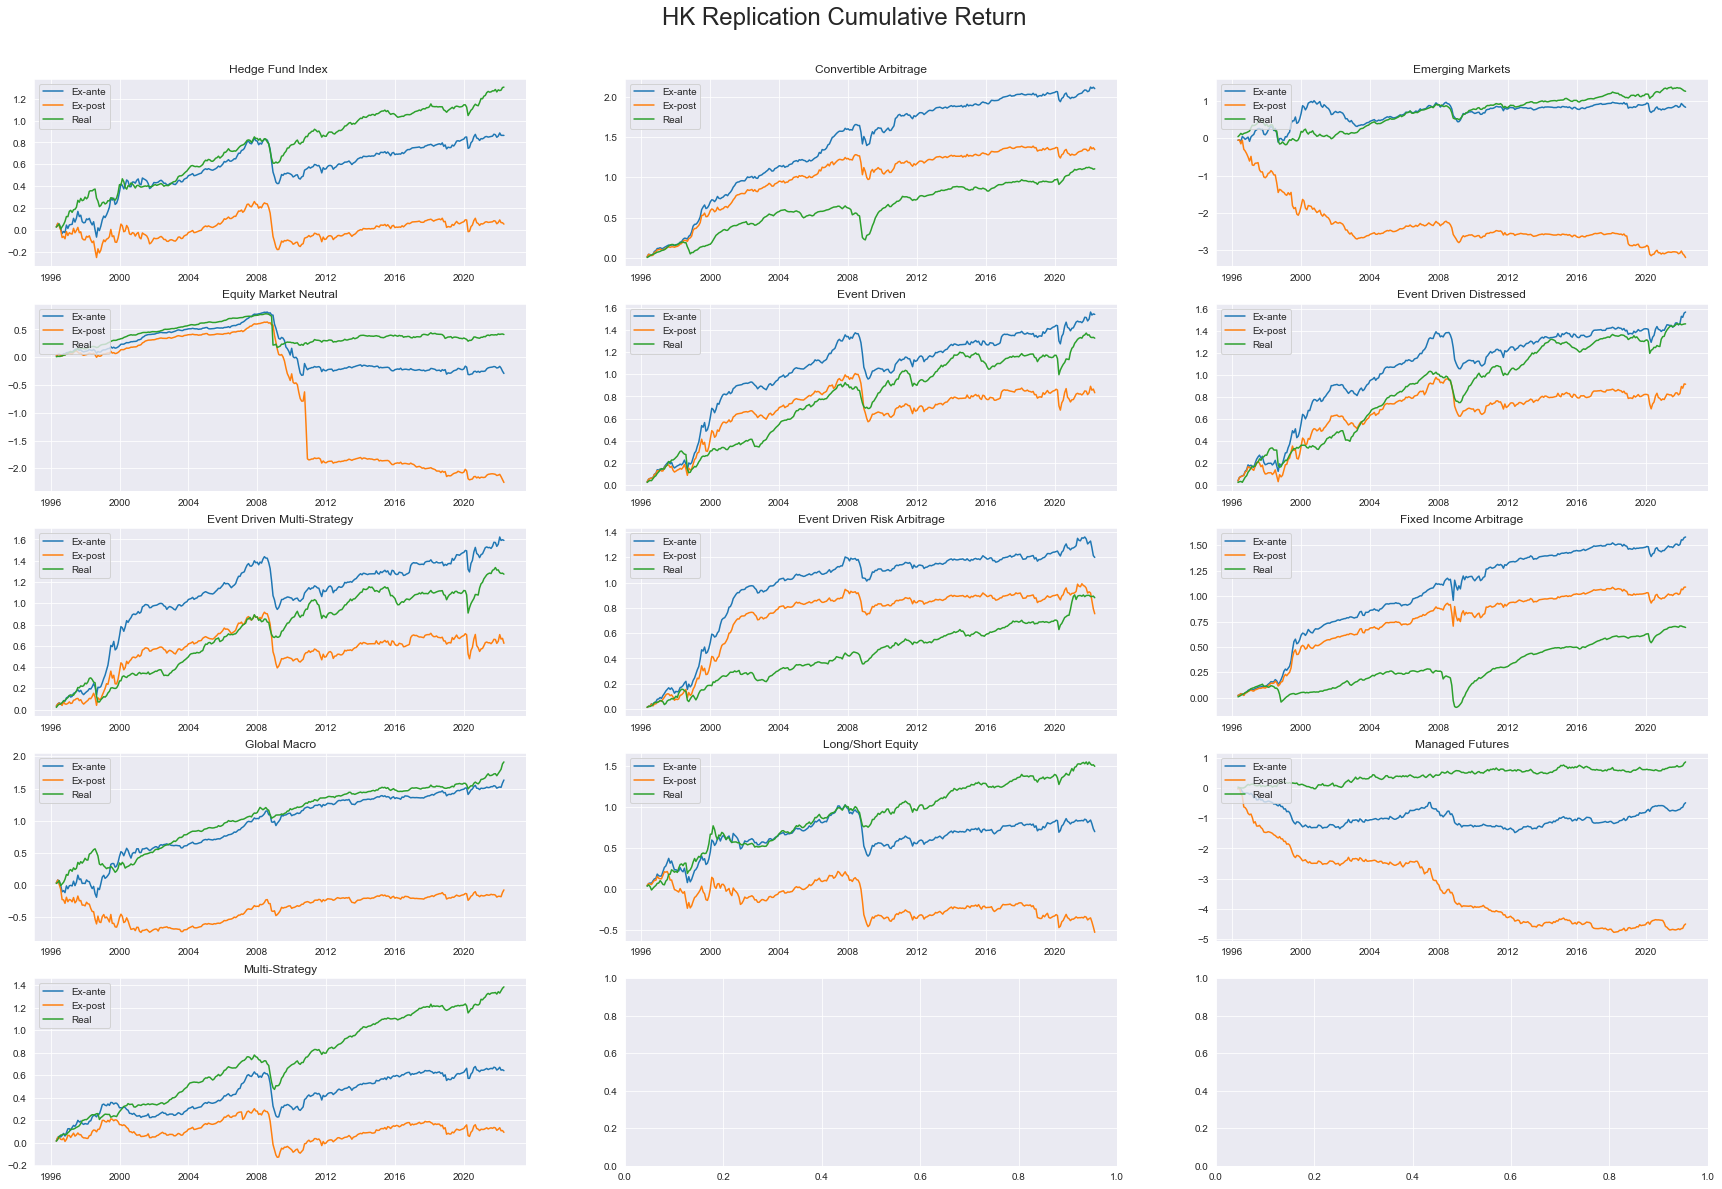

In [94]:
fig, ax = plt.subplots(5, 3, figsize=(30, 20))
row, col = 0, 0
for idx, strat in enumerate(OLS_HK_ret.columns):
    temp = pd.DataFrame(
        [ OLS_HK_ret.iloc[:, idx].cumsum(), OLS_ret_hk_ex_post.iloc[:, idx].cumsum(), hfd.iloc[24:, idx].cumsum()],
        index=['Ex-ante', 'Ex-post', 'Real']).T
    for i, name in enumerate(temp.columns):
        ax[row][col].plot(temp.iloc[:, i], label=name)
        ax[row][col].legend(loc="upper left")
    ax[row][col].set_title(hfd_fullname[strat])
    col += 1
    if col % 3 == 0:
        row += 1
        col = 0
plt.suptitle("HK Replication Cumulative Return", y=0.93, fontsize=24)
plt.show()

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(30,20))
row,col = 0, 0
for idx,strat in enumerate(OLS_HK_ret.columns):
    temp = pd.DataFrame([OLS_ret_hk_ex_post.iloc[:,idx].cumsum(),OLS_HK_ret.iloc[:,idx].cumsum(),hfd.iloc[24: ,idx].cumsum()],index=['Ex-post','Ex-ante','Real']).T
    for i,name in enumerate(temp.columns):
        ax[row][col].hist(temp.iloc[:,i],label = name,bins=30,alpha=0.7)
        ax[row][col].legend(loc="upper left")
    ax[row][col].set_title(hfd_fullname[strat])
    col +=1
    if col % 3 == 0:
        row += 1
        col = 0
plt.suptitle("OLS_HK_Replication Comparison",y=0.93,fontsize=24)
plt.show()

In [ ]:
def tracking_error(df,name):
    OOS_hfd = hfd.iloc[window:] + OOS_rf.values  # hedge fund with rf
    OLS_metrics = []
    for strat in df.columns:
        metrics = [
            mean_squared_error(OOS_hfd[strat].cumsum(), df[strat].cumsum(), squared=False),
            # r2_score(OOS_hfd[strat].cumsum(), df[strat].cumsum())
        ]
        OLS_metrics.append(metrics)
    return pd.DataFrame(OLS_metrics, columns=[
        F'{name}_RMSE',
        # f'{name}_R2'
    ], index=hfd_fullname.values())

In [ ]:
track = tracking_error(OLS_HK_ret,'OLS_HK_Ante').join(tracking_error(OLS_ret,'OLS_Ante')).join(tracking_error(OLS_ret_hk_ex_post,'OLS_HK_Post')).join(tracking_error(OLS_ret_ex_post,'OLS_Post'))
track

In [ ]:
px.bar(track)

In [ ]:
def tracking_error(df, name):
    OOS_hfd = hfd.iloc[window:] + OOS_rf.values  # hedge fund with rf
    OLS_metrics = []
    for strat in df.columns:
        metrics = [
            mean_squared_error(OOS_hfd[strat].cumsum(), df[strat].cumsum(), squared=False),
            r2_score(OOS_hfd[strat].cumsum(), df[strat].cumsum())
        ]
        OLS_metrics.append(metrics)
    return pd.DataFrame(OLS_metrics, columns=[
        F'{name}_RMSE',
        f'{name}_R2'
    ], index=hfd_fullname.values())


track = tracking_error(OLS_HK_ret, 'OLS_HK_Ante').join(tracking_error(OLS_ret, 'OLS_Ante')).join(
    tracking_error(OLS_ret_hk_ex_post, 'OLS_HK_Post')).join(tracking_error(OLS_ret_ex_post, 'OLS_Post'))
track

# Export processed data

In [ ]:
hfd.to_csv('cleaned_data/hfd.csv')
factor_etf_data.to_csv('cleaned_data/factor_etf_data.csv')

In [ ]:
def dic_read(loc):
    a_file = open(loc, "rb")
    output = pickle.load(a_file)
    return output

def dic_save(dic,loc):
    a_file = open(loc,'wb')
    pickle.dump(dic,a_file)
    a_file.close()
    # test if readable
    output = dic_read(loc)
    print('stored dictionary:\n')
    print(output)

In [ ]:
dic_save(hfd_fullname,'cleaned_data/hfd_fullname.pkl')

In [ ]:
dic_save(factor_etf_name,'cleaned_data/factor_etf_name.pkl')